**Chapter 11 – Deep Learning**

_This notebook contains all the sample code and solutions to the exercises in chapter 11._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Vanishing/Exploding Gradients Problem

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

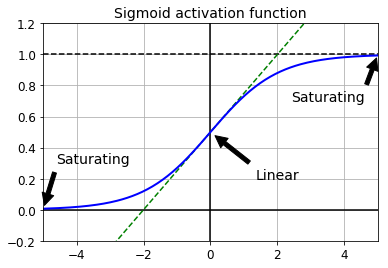

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

#save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

Note: the book uses `tensorflow.contrib.layers.fully_connected()` rather than `tf.layers.dense()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dense()`, because anything in the contrib module may change or be deleted without notice. The `dense()` function is almost identical to the `fully_connected()` function. The main differences relevant to this chapter are:
* several parameters are renamed: `scope` becomes `name`, `activation_fn` becomes `activation` (and similarly the `_fn` suffix is removed from other parameters such as `normalizer_fn`), `weights_initializer` becomes `kernel_initializer`, etc.
* the default `activation` is now `None` rather than `tf.nn.relu`.
* it does not support `tensorflow.contrib.framework.arg_scope()` (introduced later in chapter 11).
* it does not support regularizer params (introduced later in chapter 11).

In [4]:
import tensorflow as tf

In [5]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [6]:
he_init = tf.contrib.layers.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

## Nonsaturating Activation Functions

### Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

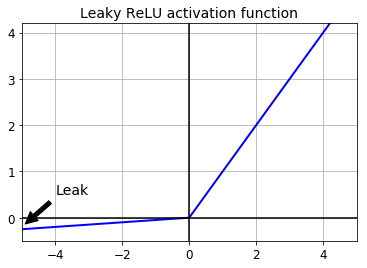

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

#save_fig("leaky_relu_plot")
plt.show()

Implementing Leaky ReLU in TensorFlow:

In [9]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [10]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

Let's train a neural network on MNIST using the Leaky ReLU. First let's create the graph:

In [11]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [12]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [13]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [14]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [15]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [16]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [17]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Let's load the data:

In [18]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [19]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_test = accuracy.eval(feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
            print(epoch, "Batch accuracy:", acc_train, "Validation accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy: 0.9044
5 Batch accuracy: 0.94 Validation accuracy: 0.9508
10 Batch accuracy: 0.96 Validation accuracy: 0.9666
15 Batch accuracy: 1.0 Validation accuracy: 0.9722
20 Batch accuracy: 1.0 Validation accuracy: 0.975
25 Batch accuracy: 1.0 Validation accuracy: 0.9766
30 Batch accuracy: 0.98 Validation accuracy: 0.9782
35 Batch accuracy: 0.96 Validation accuracy: 0.9792


### ELU

In [20]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

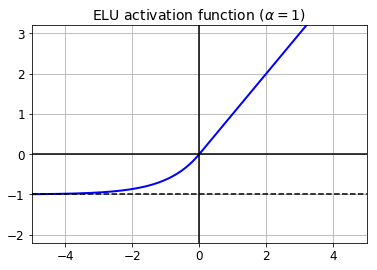

In [21]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

#save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [22]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [23]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017 (I will definitely add it to the book). It outperforms the other activation functions very significantly for deep neural networks, so you should really try it out.

In [24]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

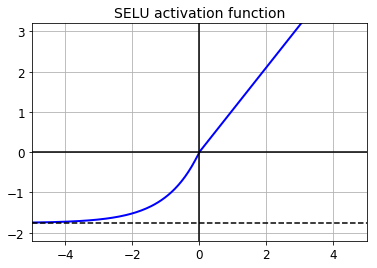

In [25]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

#save_fig("selu_plot")
plt.show()

With this activation function, even a 100 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [26]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print("Layer {}: {:.2f} < mean < {:.2f}, {:.2f} < std deviation < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

Layer 0: -0.26 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 10: -0.24 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 20: -0.17 < mean < 0.18, 0.74 < std deviation < 1.24
Layer 30: -0.27 < mean < 0.24, 0.78 < std deviation < 1.20
Layer 40: -0.38 < mean < 0.39, 0.74 < std deviation < 1.25
Layer 50: -0.27 < mean < 0.31, 0.73 < std deviation < 1.27
Layer 60: -0.26 < mean < 0.43, 0.74 < std deviation < 1.35
Layer 70: -0.19 < mean < 0.21, 0.75 < std deviation < 1.21
Layer 80: -0.18 < mean < 0.16, 0.72 < std deviation < 1.19
Layer 90: -0.19 < mean < 0.16, 0.75 < std deviation < 1.20


Here's a TensorFlow implementation (there will almost certainly be a `tf.nn.selu()` function in future TensorFlow versions):

In [27]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

SELUs can also be combined with dropout, check out [this implementation](https://github.com/bioinf-jku/SNNs/blob/master/selu.py) by the Institute of Bioinformatics, Johannes Kepler University Linz.

Let's create a neural net for MNIST using the SELU activation function:

In [28]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [29]:
means = mnist.train.images.mean(axis=0, keepdims=True)
stds = mnist.train.images.std(axis=0, keepdims=True) + 1e-10

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            X_val_scaled = (mnist.validation.images - means) / stds
            acc_test = accuracy.eval(feed_dict={X: X_val_scaled, y: mnist.validation.labels})
            print(epoch, "Batch accuracy:", acc_train, "Validation accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 Batch accuracy: 0.96 Validation accuracy: 0.924
5 Batch accuracy: 1.0 Validation accuracy: 0.9568
10 Batch accuracy: 0.94 Validation accuracy: 0.9668
15 Batch accuracy: 0.98 Validation accuracy: 0.9684
20 Batch accuracy: 1.0 Validation accuracy: 0.9712
25 Batch accuracy: 1.0 Validation accuracy: 0.9694
30 Batch accuracy: 1.0 Validation accuracy: 0.97
35 Batch accuracy: 1.0 Validation accuracy: 0.971


# Batch Normalization

Note: the book uses `tensorflow.contrib.layers.batch_norm()` rather than `tf.layers.batch_normalization()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.batch_normalization()`, because anything in the contrib module may change or be deleted without notice. Instead of using the `batch_norm()` function as a regularizer parameter to the `fully_connected()` function, we now use `batch_normalization()` and we explicitly create a distinct layer. The parameters are a bit different, in particular:
* `decay` is renamed to `momentum`,
* `is_training` is renamed to `training`,
* `updates_collections` is removed: the update operations needed by batch normalization are added to the `UPDATE_OPS` collection and you need to explicity run these operations during training (see the execution phase below),
* we don't need to specify `scale=True`, as that is the default.

Also note that in order to run batch norm just _before_ each hidden layer's activation function, we apply the ELU activation function manually, right after the batch norm layer.

Note: since the `tf.layers.dense()` function is incompatible with `tf.contrib.layers.arg_scope()` (which is used in the book), we now use python's `functools.partial()` function instead. It makes it easy to create a `my_dense_layer()` function that just calls `tf.layers.dense()` with the desired parameters automatically set (unless they are overridden when calling `my_dense_layer()`). As you can see, the code remains very similar.

In [30]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

In [31]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

To avoid repeating the same parameters over and over again, we can use Python's `partial()` function:

In [32]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

Let's build a neural net for MNIST, using the ELU activation function and Batch Normalization at each layer:

In [33]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.contrib.layers.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Note: since we are using `tf.layers.batch_normalization()` rather than `tf.contrib.layers.batch_norm()` (as in the book), we need to explicitly run the extra update operations needed by batch normalization (`sess.run([training_op, extra_update_ops],...`).

In [34]:
n_epochs = 20
batch_size = 200

In [35]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy: 0.8652
1 Test accuracy: 0.8961
2 Test accuracy: 0.9122
3 Test accuracy: 0.9222
4 Test accuracy: 0.929
5 Test accuracy: 0.9351
6 Test accuracy: 0.9379
7 Test accuracy: 0.9435
8 Test accuracy: 0.9451
9 Test accuracy: 0.9485
10 Test accuracy: 0.951
11 Test accuracy: 0.9532
12 Test accuracy: 0.9555
13 Test accuracy: 0.9576
14 Test accuracy: 0.9597
15 Test accuracy: 0.9609
16 Test accuracy: 0.9615
17 Test accuracy: 0.9634
18 Test accuracy: 0.9641
19 Test accuracy: 0.965


What!? That's not a great accuracy for MNIST. Of course, if you train for longer it will get much better accuracy, but with such a shallow network, Batch Norm and ELU are unlikely to have very positive impact: they shine mostly for much deeper nets.

Note that you could also make the training operation depend on the update operations:

```python
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)
```

This way, you would just have to evaluate the `training_op` during training, TensorFlow would automatically run the update operations as well:

```python
sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
```

One more thing: notice that the list of trainable variables is shorter than the list of all global variables. This is because the moving averages are non-trainable variables. If you want to reuse a pretrained neural network (see below), you must not forget these non-trainable variables.

In [36]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [37]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

## Gradient Clipping

Let's create a simple neural net for MNIST and add gradient clipping. The first part is the same as earlier (except we added a few more layers to demonstrate reusing pretrained models, see below):

In [38]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [39]:
learning_rate = 0.01

Now we apply gradient clipping. For this, we need to get the gradients, use the `clip_by_value()` function to clip them, then apply them:

In [40]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

The rest is the same as usual:

In [41]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [42]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [43]:
n_epochs = 20
batch_size = 200

In [44]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy: 0.3139
1 Test accuracy: 0.8001
2 Test accuracy: 0.8806
3 Test accuracy: 0.9037
4 Test accuracy: 0.9124
5 Test accuracy: 0.9197
6 Test accuracy: 0.9243
7 Test accuracy: 0.9299
8 Test accuracy: 0.9331
9 Test accuracy: 0.9387
10 Test accuracy: 0.9431
11 Test accuracy: 0.9445
12 Test accuracy: 0.9455
13 Test accuracy: 0.9485
14 Test accuracy: 0.9524
15 Test accuracy: 0.9511
16 Test accuracy: 0.9562
17 Test accuracy: 0.9583
18 Test accuracy: 0.9559
19 Test accuracy: 0.9605


## Reusing Pretrained Layers

## Reusing a TensorFlow Model

First you need to load the graph's structure. The `import_meta_graph()` function does just that, loading the graph's operations into the default graph, and returning a `Saver` that you can then use to restore the model's state. Note that by default, a `Saver` saves the structure of the graph into a `.meta` file, so that's the file you should load:

In [45]:
reset_graph()

In [46]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

Next you need to get a handle on all the operations you will need for training. If you don't know the graph's structure, you can list all the operations:

In [47]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

Oops, that's a lot of operations! It's much easier to use TensorBoard to visualize the graph. The following hack will allow you to visualize the graph within Jupyter (if it does not work with your browser, you will need to use a `FileWriter` to save the graph and then visualize it in TensorBoard):

In [48]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [49]:
show_graph(tf.get_default_graph())

Once you know which operations you need, you can get a handle on them using the graph's `get_operation_by_name()` or `get_tensor_by_name()` methods:

In [50]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

If you are the author of the original model, you could make things easier for people who will reuse your model by giving operations very clear names and documenting them. Another approach is to create a collection containing all the important operations that people will want to get a handle on:

In [51]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

This way people who reuse your model will be able to simply write:

In [52]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

Now you can start a session, restore the model's state and continue training on your data:

In [53]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    # continue training the model...

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


Actually, let's test this for real!

In [54]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9609
1 Test accuracy: 0.9608
2 Test accuracy: 0.9617
3 Test accuracy: 0.9613
4 Test accuracy: 0.9639
5 Test accuracy: 0.9649
6 Test accuracy: 0.9663
7 Test accuracy: 0.9627
8 Test accuracy: 0.9665
9 Test accuracy: 0.9669
10 Test accuracy: 0.9662
11 Test accuracy: 0.9674
12 Test accuracy: 0.9678
13 Test accuracy: 0.9679
14 Test accuracy: 0.9688
15 Test accuracy: 0.9684
16 Test accuracy: 0.9687
17 Test accuracy: 0.9702
18 Test accuracy: 0.9673
19 Test accuracy: 0.9687


Alternatively, if you have access to the Python code that built the original graph, you can use it instead of `import_meta_graph()`:

In [55]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

And continue training:

In [56]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9611
1 Test accuracy: 0.9619
2 Test accuracy: 0.9622
3 Test accuracy: 0.9619
4 Test accuracy: 0.9644
5 Test accuracy: 0.9633
6 Test accuracy: 0.9647
7 Test accuracy: 0.9648
8 Test accuracy: 0.9671
9 Test accuracy: 0.9677
10 Test accuracy: 0.9676
11 Test accuracy: 0.9679
12 Test accuracy: 0.9687
13 Test accuracy: 0.9688
14 Test accuracy: 0.9683
15 Test accuracy: 0.9693
16 Test accuracy: 0.9677
17 Test accuracy: 0.9697
18 Test accuracy: 0.9692
19 Test accuracy: 0.9707


In general you will want to reuse only the lower layers. If you are using `import_meta_graph()` it will load the whole graph, but you can simply ignore the parts you do not need. In this example, we add a new 4th hidden layer on top of the pretrained 3rd layer (ignoring the old 4th hidden layer). We also build a new output layer, the loss for this new output, and a new optimizer to minimize it. We also need another saver to save the whole graph (containing both the entire old graph plus the new operations), and an initialization operation to initialize all the new variables:

In [57]:
reset_graph()

n_hidden4 = 20  # new layer
n_outputs = 10  # new layer

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden4/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

And we can train this new model:

In [58]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9026
1 Test accuracy: 0.9327
2 Test accuracy: 0.9451
3 Test accuracy: 0.9529
4 Test accuracy: 0.9554
5 Test accuracy: 0.9571
6 Test accuracy: 0.9558
7 Test accuracy: 0.9596
8 Test accuracy: 0.9592
9 Test accuracy: 0.9599
10 Test accuracy: 0.9614
11 Test accuracy: 0.9589
12 Test accuracy: 0.9635
13 Test accuracy: 0.966
14 Test accuracy: 0.9628
15 Test accuracy: 0.9642
16 Test accuracy: 0.9654
17 Test accuracy: 0.9671
18 Test accuracy: 0.9674
19 Test accuracy: 0.9668


If you have access to the Python code that built the original graph, you can just reuse the parts you need and drop the rest:

In [59]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

However, you must create one `Saver` to restore the pretrained model (giving it the list of variables to restore, or else it will complain that the graphs don't match), and another `Saver` to save the new model, once it is trained:

In [60]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):                                      # not shown in the book
        for iteration in range(mnist.train.num_examples // batch_size): # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)      # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})  # not shown
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,  # not shown
                                                y: mnist.test.labels}) # not shown
        print(epoch, "Test accuracy:", accuracy_val)                   # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9022
1 Test accuracy: 0.9302
2 Test accuracy: 0.9393
3 Test accuracy: 0.9429
4 Test accuracy: 0.9484
5 Test accuracy: 0.9511
6 Test accuracy: 0.9517
7 Test accuracy: 0.9539
8 Test accuracy: 0.9545
9 Test accuracy: 0.9572
10 Test accuracy: 0.9599
11 Test accuracy: 0.9602
12 Test accuracy: 0.9606
13 Test accuracy: 0.9619
14 Test accuracy: 0.9619
15 Test accuracy: 0.9636
16 Test accuracy: 0.9633
17 Test accuracy: 0.9643
18 Test accuracy: 0.9651
19 Test accuracy: 0.9657


## Reusing Models from Other Frameworks

In this example, for each variable we want to reuse, we find its initializer's assignment operation, and we get its second input, which corresponds to the initialization value. When we run the initializer, we replace the initialization values with the ones we want, using a `feed_dict`:

In [61]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [62]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))  # not shown in the book

[[  61.   83.  105.]]


Note: the weights variable created by the `tf.layers.dense()` function is called `"kernel"` (instead of `"weights"` when using the `tf.contrib.layers.fully_connected()`, as in the book), and the biases variable is called `bias` instead of `biases`.

Another approach (initially used in the book) would be to create dedicated assignment nodes and dedicated placeholders. This is more verbose and less efficient, but you may find this more explicit:

In [63]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the variables of layer hidden1
with tf.variable_scope("", default_name="", reuse=True):  # root scope
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# Create dedicated placeholders and assignment nodes
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[  61.   83.  105.]]


Note that we could also get a handle on the variables using `get_collection()` and specifying the `scope`:

In [64]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

Or we could use the graph's `get_tensor_by_name()` method:

In [65]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [66]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

### Freezing the Lower Layers

In [67]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [68]:
with tf.name_scope("train"):                                         # not shown in the book
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # not shown
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [69]:
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [70]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.8987
1 Test accuracy: 0.9311
2 Test accuracy: 0.9375
3 Test accuracy: 0.9414
4 Test accuracy: 0.9437
5 Test accuracy: 0.9479
6 Test accuracy: 0.9495
7 Test accuracy: 0.9521
8 Test accuracy: 0.9517
9 Test accuracy: 0.9525
10 Test accuracy: 0.9535
11 Test accuracy: 0.9538
12 Test accuracy: 0.9534
13 Test accuracy: 0.9546
14 Test accuracy: 0.9538
15 Test accuracy: 0.9553
16 Test accuracy: 0.9552
17 Test accuracy: 0.9549
18 Test accuracy: 0.9553
19 Test accuracy: 0.9557


In [71]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [72]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

In [73]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

The training code is exactly the same as earlier:

In [74]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9031
1 Test accuracy: 0.932
2 Test accuracy: 0.94
3 Test accuracy: 0.9435
4 Test accuracy: 0.9473
5 Test accuracy: 0.9492
6 Test accuracy: 0.9498
7 Test accuracy: 0.9493
8 Test accuracy: 0.9515
9 Test accuracy: 0.9519
10 Test accuracy: 0.9529
11 Test accuracy: 0.9536
12 Test accuracy: 0.9529
13 Test accuracy: 0.9532
14 Test accuracy: 0.9522
15 Test accuracy: 0.9534
16 Test accuracy: 0.953
17 Test accuracy: 0.955
18 Test accuracy: 0.955
19 Test accuracy: 0.9552


### Caching the Frozen Layers

In [75]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen & cached
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [76]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [77]:
import numpy as np

n_batches = mnist.train.num_examples // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: mnist.train.images})
    h2_cache_test = sess.run(hidden2, feed_dict={X: mnist.test.images}) # not shown in the book

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(mnist.train.num_examples)
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(mnist.train.labels[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_test, # not shown
                                                y: mnist.test.labels})  # not shown
        print(epoch, "Test accuracy:", accuracy_val)                    # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9033
1 Test accuracy: 0.9322
2 Test accuracy: 0.9423
3 Test accuracy: 0.9449
4 Test accuracy: 0.9471
5 Test accuracy: 0.9477
6 Test accuracy: 0.951
7 Test accuracy: 0.9507
8 Test accuracy: 0.9514
9 Test accuracy: 0.9522
10 Test accuracy: 0.9512
11 Test accuracy: 0.9521
12 Test accuracy: 0.9522
13 Test accuracy: 0.9539
14 Test accuracy: 0.9536
15 Test accuracy: 0.9534
16 Test accuracy: 0.9547
17 Test accuracy: 0.9537
18 Test accuracy: 0.9542
19 Test accuracy: 0.9547


# Faster Optimizers

## Momentum optimization

In [78]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

## Nesterov Accelerated Gradient

In [79]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

## AdaGrad

In [80]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

## RMSProp

In [81]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

## Adam Optimization

In [82]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Learning Rate Scheduling

In [83]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [84]:
with tf.name_scope("train"):       # not shown in the book
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [85]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [86]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy: 0.9579
1 Test accuracy: 0.9691
2 Test accuracy: 0.976
3 Test accuracy: 0.9793
4 Test accuracy: 0.9811


# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

Let's implement $\ell_1$ regularization manually. First, we create the model, as usual (with just one hidden layer this time, for simplicity):

In [87]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

Next, we get a handle on the layer weights, and we compute the total loss, which is equal to the sum of the usual cross entropy loss and the $\ell_1$ loss (i.e., the absolute values of the weights):

In [88]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 regularization hyperparameter

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

The rest is just as usual:

In [89]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [90]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy: 0.8343
1 Test accuracy: 0.8726
2 Test accuracy: 0.8832
3 Test accuracy: 0.8899
4 Test accuracy: 0.8958
5 Test accuracy: 0.8986
6 Test accuracy: 0.9011
7 Test accuracy: 0.9032
8 Test accuracy: 0.9046
9 Test accuracy: 0.9047
10 Test accuracy: 0.9065
11 Test accuracy: 0.9059
12 Test accuracy: 0.9072
13 Test accuracy: 0.9072
14 Test accuracy: 0.9069
15 Test accuracy: 0.9071
16 Test accuracy: 0.9064
17 Test accuracy: 0.9071
18 Test accuracy: 0.9068
19 Test accuracy: 0.9063


Alternatively, we can pass a regularization function to the `tf.layers.dense()` function, which will use it to create operations that will compute the regularization loss, and it adds these operations to the collection of regularization losses. The beginning is the same as above:

In [91]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

Next, we will use Python's `partial()` function to avoid repeating the same arguments over and over again. Note that we set the `kernel_regularizer` argument:

In [92]:
scale = 0.001

In [93]:
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")

Next we must add the regularization losses to the base loss:

In [94]:
with tf.name_scope("loss"):                                     # not shown in the book
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  # not shown
        labels=y, logits=logits)                                # not shown
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   # not shown
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

And the rest is the same as usual:

In [95]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [96]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy: 0.8298
1 Test accuracy: 0.8778
2 Test accuracy: 0.8917
3 Test accuracy: 0.9017
4 Test accuracy: 0.9068
5 Test accuracy: 0.9103
6 Test accuracy: 0.9125
7 Test accuracy: 0.9137
8 Test accuracy: 0.9149
9 Test accuracy: 0.9174
10 Test accuracy: 0.9176
11 Test accuracy: 0.9184
12 Test accuracy: 0.9191
13 Test accuracy: 0.9183
14 Test accuracy: 0.9195
15 Test accuracy: 0.9201
16 Test accuracy: 0.9181
17 Test accuracy: 0.9184
18 Test accuracy: 0.9181
19 Test accuracy: 0.9174


## Dropout

Note: the book uses `tf.contrib.layers.dropout()` rather than `tf.layers.dropout()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dropout()`, because anything in the contrib module may change or be deleted without notice. The `tf.layers.dropout()` function is almost identical to the `tf.contrib.layers.dropout()` function, except for a few minor differences. Most importantly:
* you must specify the dropout rate (`rate`) rather than the keep probability (`keep_prob`), where `rate` is simply equal to `1 - keep_prob`,
* the `is_training` parameter is renamed to `training`.

In [97]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [98]:
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

In [99]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [100]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Test accuracy: 0.9205
1 Test accuracy: 0.9418
2 Test accuracy: 0.9486
3 Test accuracy: 0.9508
4 Test accuracy: 0.954
5 Test accuracy: 0.957
6 Test accuracy: 0.9604
7 Test accuracy: 0.9585
8 Test accuracy: 0.9598
9 Test accuracy: 0.9663
10 Test accuracy: 0.9644
11 Test accuracy: 0.9646
12 Test accuracy: 0.9675
13 Test accuracy: 0.9657
14 Test accuracy: 0.9645
15 Test accuracy: 0.9668
16 Test accuracy: 0.969
17 Test accuracy: 0.9682
18 Test accuracy: 0.9698
19 Test accuracy: 0.9682


## Max norm

Let's go back to a plain and simple neural net for MNIST with just 2 hidden layers:

In [101]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Next, let's get a handle on the first hidden layer's weight and create an operation that will compute the clipped weights using the `clip_by_norm()` function. Then we create an assignment operation to assign the clipped weights to the weights variable:

In [102]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

We can do this as well for the second hidden layer:

In [103]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

Let's add an initializer and a saver:

In [104]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

And now we can train the model. It's pretty much as usual, except that right after running the `training_op`, we run the `clip_weights` and `clip_weights2` operations:

In [105]:
n_epochs = 20
batch_size = 50

In [106]:
with tf.Session() as sess:                                              # not shown in the book
    init.run()                                                          # not shown
    for epoch in range(n_epochs):                                       # not shown
        for iteration in range(mnist.train.num_examples // batch_size):  # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)       # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        # not shown
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images,       # not shown
                                            y: mnist.test.labels})      # not shown
        print(epoch, "Test accuracy:", acc_test)                        # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")               # not shown

0 Test accuracy: 0.9517
1 Test accuracy: 0.9674
2 Test accuracy: 0.9712
3 Test accuracy: 0.9759
4 Test accuracy: 0.975
5 Test accuracy: 0.9761
6 Test accuracy: 0.9765
7 Test accuracy: 0.9796
8 Test accuracy: 0.9791
9 Test accuracy: 0.9794
10 Test accuracy: 0.9805
11 Test accuracy: 0.9809
12 Test accuracy: 0.9807
13 Test accuracy: 0.9799
14 Test accuracy: 0.982
15 Test accuracy: 0.9816
16 Test accuracy: 0.9825
17 Test accuracy: 0.9825
18 Test accuracy: 0.9816
19 Test accuracy: 0.9822


The implementation above is straightforward and it works fine, but it is a bit messy. A better approach is to define a `max_norm_regularizer()` function:

In [107]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

Then you can call this function to get a max norm regularizer (with the threshold you want). When you create a hidden layer, you can pass this regularizer to the `kernel_regularizer` argument:

In [108]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [109]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [110]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Training is as usual, except you must run the weights clipping operations after each training operation:

In [111]:
n_epochs = 20
batch_size = 50

In [112]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images,     # not shown in the book
                                            y: mnist.test.labels})    # not shown
        print(epoch, "Test accuracy:", acc_test)                      # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")             # not shown

0 Test accuracy: 0.9527
1 Test accuracy: 0.9653
2 Test accuracy: 0.97
3 Test accuracy: 0.9751
4 Test accuracy: 0.9752
5 Test accuracy: 0.9742
6 Test accuracy: 0.9754
7 Test accuracy: 0.9784
8 Test accuracy: 0.9775
9 Test accuracy: 0.9789
10 Test accuracy: 0.9808
11 Test accuracy: 0.9797
12 Test accuracy: 0.9802
13 Test accuracy: 0.9799
14 Test accuracy: 0.9808
15 Test accuracy: 0.9809
16 Test accuracy: 0.9807
17 Test accuracy: 0.9803
18 Test accuracy: 0.9816
19 Test accuracy: 0.9812


# Exercise solutions

## 1. to 7.

See appendix A.

## 8. Deep Learning

### 8.1.

_Exercise: Build a DNN with five hidden layers of 100 neurons each, He initialization, and the ELU activation function._

We will need similar DNNs in the next exercises, so let's create a function to build this DNN:

In [113]:
he_init = tf.contrib.layers.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

In [114]:
n_inputs = 28 * 28 # MNIST
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

### 8.2.

_Exercise: Using Adam optimization and early stopping, try training it on MNIST but only on digits 0 to 4, as we will use transfer learning for digits 5 to 9 in the next exercise. You will need a softmax output layer with five neurons, and as always make sure to save checkpoints at regular intervals and save the final model so you can reuse it later._

Let's complete the graph with the cost function, the training op, and all the other usual components:

In [115]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Let's fetch the MNIST dataset:

In [116]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Now let's create the training set, validation and test set (we need the validation set to implement early stopping):

In [117]:
X_train1 = mnist.train.images[mnist.train.labels < 5]
y_train1 = mnist.train.labels[mnist.train.labels < 5]
X_valid1 = mnist.validation.images[mnist.validation.labels < 5]
y_valid1 = mnist.validation.labels[mnist.validation.labels < 5]
X_test1 = mnist.test.images[mnist.test.labels < 5]
y_test1 = mnist.test.labels[mnist.test.labels < 5]

In [118]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

0	Validation loss: 0.129281	Best loss: 0.129281	Accuracy: 97.03%
1	Validation loss: 0.085987	Best loss: 0.085987	Accuracy: 97.62%
2	Validation loss: 0.163253	Best loss: 0.085987	Accuracy: 96.87%
3	Validation loss: 0.111381	Best loss: 0.085987	Accuracy: 97.07%
4	Validation loss: 0.130923	Best loss: 0.085987	Accuracy: 96.99%
5	Validation loss: 0.123629	Best loss: 0.085987	Accuracy: 98.28%
6	Validation loss: 0.167125	Best loss: 0.085987	Accuracy: 96.79%
7	Validation loss: 0.123174	Best loss: 0.085987	Accuracy: 97.38%
8	Validation loss: 0.120984	Best loss: 0.085987	Accuracy: 97.34%
9	Validation loss: 0.123353	Best loss: 0.085987	Accuracy: 97.69%
10	Validation loss: 0.557742	Best loss: 0.085987	Accuracy: 94.37%
11	Validation loss: 0.262050	Best loss: 0.085987	Accuracy: 96.83%
12	Validation loss: 5.188450	Best loss: 0.085987	Accuracy: 94.29%
13	Validation loss: 0.392812	Best loss: 0.085987	Accuracy: 96.60%
14	Validation loss: 0.457959	Best loss: 0.085987	Accuracy: 79.32%
15	Validation loss: 

We get 98.05% accuracy on the test set. That's not too bad, but let's see if we can do better by tuning the hyperparameters.

### 8.3.

_Exercise: Tune the hyperparameters using cross-validation and see what precision you can achieve._

Let's create a `DNNClassifier` class, compatible with Scikit-Learn's `RandomizedSearchCV` class, to perform hyperparameter tuning. Here are the key points of this implementation:
* the `__init__()` method (constructor) does nothing more than create instance variables for each of the hyperparameters.
* the `fit()` method creates the graph, starts a session and trains the model:
  * it calls the `_build_graph()` method to build the graph (much lile the graph we defined earlier). Once this method is done creating the graph, it saves all the important operations as instance variables for easy access by other methods.
  * the `_dnn()` method builds the hidden layers, just like the `dnn()` function above, but also with support for batch normalization and dropout (for the next exercises).
  * if the `fit()` method is given a validation set (`X_valid` and `y_valid`), then it implements early stopping. This implementation does not save the best model to disk, but rather to memory: it uses the `_get_model_params()` method to get all the graph's variables and their values, and the `_restore_model_params()` method to restore the variable values (of the best model found). This trick helps speed up training.
  * After the `fit()` method has finished training the model, it keeps the session open so that predictions can be made quickly, without having to save a model to disk and restore it for every prediction. You can close the session by calling the `close_session()` method.
* the `predict_proba()` method uses the trained model to predict the class probabilities.
* the `predict()` method calls `predict_proba()` and returns the class with the highest probability, for each instance.

In [119]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

Let's see if we get the exact same accuracy as earlier using this class (without dropout or batch norm):

In [120]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.129281	Best loss: 0.129281	Accuracy: 97.03%
1	Validation loss: 0.085987	Best loss: 0.085987	Accuracy: 97.62%
2	Validation loss: 0.163253	Best loss: 0.085987	Accuracy: 96.87%
3	Validation loss: 0.111381	Best loss: 0.085987	Accuracy: 97.07%
4	Validation loss: 0.130923	Best loss: 0.085987	Accuracy: 96.99%
5	Validation loss: 0.123629	Best loss: 0.085987	Accuracy: 98.28%
6	Validation loss: 0.167125	Best loss: 0.085987	Accuracy: 96.79%
7	Validation loss: 0.123174	Best loss: 0.085987	Accuracy: 97.38%
8	Validation loss: 0.120984	Best loss: 0.085987	Accuracy: 97.34%
9	Validation loss: 0.123353	Best loss: 0.085987	Accuracy: 97.69%
10	Validation loss: 0.557742	Best loss: 0.085987	Accuracy: 94.37%
11	Validation loss: 0.262050	Best loss: 0.085987	Accuracy: 96.83%
12	Validation loss: 5.188450	Best loss: 0.085987	Accuracy: 94.29%
13	Validation loss: 0.392812	Best loss: 0.085987	Accuracy: 96.60%
14	Validation loss: 0.457959	Best loss: 0.085987	Accuracy: 79.32%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x7f14673c2bf8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f14526b2d90>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

The model is trained, let's see if it gets the same accuracy as earlier:

In [121]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.98131932282545242

Yep! Working fine. Now we can use Scikit-Learn's `RandomizedSearchCV` class to search for better hyperparameters (this may take over an hour, depending on your system):

In [122]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                random_state=42, verbose=2)
rnd_search.fit(X_train1, y_train1)

# fit_params as a constructor argument was deprecated in Scikit-Learn version 0.19 and will
# be removed in version 0.21. Pass fit parameters to the fit() method instead:
# rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                 random_state=42, verbose=2)
# fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
# rnd_search.fit(X_train1, y_train1, **fit_params)


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=10, activation=<function elu at 0x7f14673c2bf8>, learning_rate=0.05, batch_size=100 
0	Validation loss: 0.128955	Best loss: 0.128955	Accuracy: 96.52%
1	Validation loss: 0.133592	Best loss: 0.128955	Accuracy: 97.03%
2	Validation loss: 0.112978	Best loss: 0.112978	Accuracy: 96.87%
3	Validation loss: 0.125646	Best loss: 0.112978	Accuracy: 96.56%
4	Validation loss: 0.149656	Best loss: 0.112978	Accuracy: 96.44%
5	Validation loss: 0.242129	Best loss: 0.112978	Accuracy: 94.18%
6	Validation loss: 0.800561	Best loss: 0.112978	Accuracy: 58.60%
7	Validation loss: 0.762057	Best loss: 0.112978	Accuracy: 61.34%
8	Validation loss: 0.714322	Best loss: 0.112978	Accuracy: 61.61%
9	Validation loss: 0.733769	Best loss: 0.112978	Accuracy: 59.77%
10	Validation loss: 0.726264	Best loss: 0.112978	Accuracy: 60.75%
11	Validation loss: 0.707577	Best loss: 0.112978	Accuracy: 61.92%
12	Validation loss: 0.714133	Best loss: 0.112978	Accurac

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s


0	Validation loss: 0.154466	Best loss: 0.154466	Accuracy: 95.31%
1	Validation loss: 0.110709	Best loss: 0.110709	Accuracy: 96.99%
2	Validation loss: 0.127785	Best loss: 0.110709	Accuracy: 95.86%
3	Validation loss: 0.123204	Best loss: 0.110709	Accuracy: 96.95%
4	Validation loss: 0.125416	Best loss: 0.110709	Accuracy: 96.09%
5	Validation loss: 0.163190	Best loss: 0.110709	Accuracy: 96.40%
6	Validation loss: 0.129181	Best loss: 0.110709	Accuracy: 96.64%
7	Validation loss: 0.150228	Best loss: 0.110709	Accuracy: 96.25%
8	Validation loss: 0.142415	Best loss: 0.110709	Accuracy: 96.72%
9	Validation loss: 0.138197	Best loss: 0.110709	Accuracy: 96.52%
10	Validation loss: 0.145198	Best loss: 0.110709	Accuracy: 97.15%
11	Validation loss: 0.169079	Best loss: 0.110709	Accuracy: 96.91%
12	Validation loss: 0.123248	Best loss: 0.110709	Accuracy: 96.52%
13	Validation loss: 0.177848	Best loss: 0.110709	Accuracy: 96.09%
14	Validation loss: 0.929578	Best loss: 0.110709	Accuracy: 56.53%
15	Validation loss: 

33	Validation loss: 0.089385	Best loss: 0.065762	Accuracy: 98.67%
34	Validation loss: 0.091273	Best loss: 0.065762	Accuracy: 98.16%
35	Validation loss: 0.077564	Best loss: 0.065762	Accuracy: 98.67%
36	Validation loss: 0.075940	Best loss: 0.065762	Accuracy: 98.55%
37	Validation loss: 0.078439	Best loss: 0.065762	Accuracy: 98.67%
38	Validation loss: 0.101520	Best loss: 0.065762	Accuracy: 98.59%
39	Validation loss: 0.095619	Best loss: 0.065762	Accuracy: 98.55%
40	Validation loss: 0.076094	Best loss: 0.065762	Accuracy: 98.55%
41	Validation loss: 0.070937	Best loss: 0.065762	Accuracy: 98.63%
Early stopping!
[CV]  n_neurons=30, activation=<function relu at 0x7f14673d5950>, learning_rate=0.02, batch_size=500, total=  13.8s
[CV] n_neurons=30, activation=<function relu at 0x7f14673d5950>, learning_rate=0.02, batch_size=500 
0	Validation loss: 0.121159	Best loss: 0.121159	Accuracy: 96.68%
1	Validation loss: 0.093012	Best loss: 0.093012	Accuracy: 97.11%
2	Validation loss: 0.084517	Best loss: 0.08

18	Validation loss: 10.907677	Best loss: 0.539918	Accuracy: 65.29%
19	Validation loss: 7.296910	Best loss: 0.539918	Accuracy: 61.88%
20	Validation loss: 7.996144	Best loss: 0.539918	Accuracy: 68.26%
21	Validation loss: 6.707133	Best loss: 0.539918	Accuracy: 63.64%
22	Validation loss: 5.725972	Best loss: 0.539918	Accuracy: 71.46%
23	Validation loss: 3.953042	Best loss: 0.539918	Accuracy: 80.41%
24	Validation loss: 9.402796	Best loss: 0.539918	Accuracy: 59.54%
25	Validation loss: 3.536116	Best loss: 0.539918	Accuracy: 76.51%
26	Validation loss: 3.562427	Best loss: 0.539918	Accuracy: 76.74%
Early stopping!
[CV]  n_neurons=90, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f1458b6a620>, learning_rate=0.05, batch_size=50, total=  42.3s
[CV] n_neurons=70, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f144a3ccea0>, learning_rate=0.1, batch_size=50 
0	Validation loss: 1.061083	Best loss: 1.061083	Accuracy: 86.55%
1	Validation loss: 2569379.75000

19	Validation loss: 0.085670	Best loss: 0.045088	Accuracy: 98.63%
20	Validation loss: 0.063725	Best loss: 0.045088	Accuracy: 98.48%
21	Validation loss: 0.069764	Best loss: 0.045088	Accuracy: 98.87%
22	Validation loss: 0.077341	Best loss: 0.045088	Accuracy: 98.32%
23	Validation loss: 0.060363	Best loss: 0.045088	Accuracy: 98.98%
24	Validation loss: 0.068150	Best loss: 0.045088	Accuracy: 98.59%
25	Validation loss: 0.061065	Best loss: 0.045088	Accuracy: 98.67%
Early stopping!
[CV]  n_neurons=120, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f1458b6a620>, learning_rate=0.01, batch_size=500, total=  34.1s
[CV] n_neurons=120, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f1458b6a620>, learning_rate=0.01, batch_size=500 
0	Validation loss: 0.123812	Best loss: 0.123812	Accuracy: 95.93%
1	Validation loss: 0.080252	Best loss: 0.080252	Accuracy: 97.73%
2	Validation loss: 0.066269	Best loss: 0.066269	Accuracy: 97.97%
3	Validation loss: 0.064919	Be

4	Validation loss: 0.066289	Best loss: 0.056712	Accuracy: 98.24%
5	Validation loss: 0.045372	Best loss: 0.045372	Accuracy: 98.71%
6	Validation loss: 0.039299	Best loss: 0.039299	Accuracy: 98.63%
7	Validation loss: 0.062581	Best loss: 0.039299	Accuracy: 98.36%
8	Validation loss: 0.075106	Best loss: 0.039299	Accuracy: 98.36%
9	Validation loss: 0.057095	Best loss: 0.039299	Accuracy: 98.63%
10	Validation loss: 0.058863	Best loss: 0.039299	Accuracy: 98.67%
11	Validation loss: 0.066973	Best loss: 0.039299	Accuracy: 98.59%
12	Validation loss: 0.059417	Best loss: 0.039299	Accuracy: 98.75%
13	Validation loss: 0.066265	Best loss: 0.039299	Accuracy: 98.55%
14	Validation loss: 0.056666	Best loss: 0.039299	Accuracy: 98.55%
15	Validation loss: 0.072764	Best loss: 0.039299	Accuracy: 98.40%
16	Validation loss: 0.082888	Best loss: 0.039299	Accuracy: 98.40%
17	Validation loss: 0.081743	Best loss: 0.039299	Accuracy: 98.67%
18	Validation loss: 0.072008	Best loss: 0.039299	Accuracy: 98.59%
19	Validation lo

0	Validation loss: 0.122152	Best loss: 0.122152	Accuracy: 95.93%
1	Validation loss: 0.085569	Best loss: 0.085569	Accuracy: 97.03%
2	Validation loss: 0.070516	Best loss: 0.070516	Accuracy: 98.01%
3	Validation loss: 0.049196	Best loss: 0.049196	Accuracy: 98.48%
4	Validation loss: 0.051054	Best loss: 0.049196	Accuracy: 98.71%
5	Validation loss: 0.045649	Best loss: 0.045649	Accuracy: 98.55%
6	Validation loss: 0.050156	Best loss: 0.045649	Accuracy: 98.40%
7	Validation loss: 0.043207	Best loss: 0.043207	Accuracy: 98.59%
8	Validation loss: 0.060060	Best loss: 0.043207	Accuracy: 98.28%
9	Validation loss: 0.042514	Best loss: 0.042514	Accuracy: 98.94%
10	Validation loss: 0.054234	Best loss: 0.042514	Accuracy: 98.83%
11	Validation loss: 0.049459	Best loss: 0.042514	Accuracy: 98.67%
12	Validation loss: 0.047484	Best loss: 0.042514	Accuracy: 98.94%
13	Validation loss: 0.047237	Best loss: 0.042514	Accuracy: 98.91%
14	Validation loss: 0.073716	Best loss: 0.042514	Accuracy: 98.32%
15	Validation loss: 

37	Validation loss: 1.617562	Best loss: 1.609289	Accuracy: 22.01%
38	Validation loss: 1.620767	Best loss: 1.609289	Accuracy: 20.91%
39	Validation loss: 1.627334	Best loss: 1.609289	Accuracy: 19.27%
40	Validation loss: 1.607883	Best loss: 1.607883	Accuracy: 22.01%
41	Validation loss: 1.634031	Best loss: 1.607883	Accuracy: 22.01%
42	Validation loss: 1.618327	Best loss: 1.607883	Accuracy: 20.91%
43	Validation loss: 1.618746	Best loss: 1.607883	Accuracy: 22.01%
44	Validation loss: 1.621665	Best loss: 1.607883	Accuracy: 19.08%
45	Validation loss: 1.629383	Best loss: 1.607883	Accuracy: 22.01%
46	Validation loss: 1.637658	Best loss: 1.607883	Accuracy: 18.73%
47	Validation loss: 1.609600	Best loss: 1.607883	Accuracy: 22.01%
48	Validation loss: 1.612162	Best loss: 1.607883	Accuracy: 22.01%
49	Validation loss: 1.643133	Best loss: 1.607883	Accuracy: 19.27%
50	Validation loss: 1.611987	Best loss: 1.607883	Accuracy: 22.01%
51	Validation loss: 1.619979	Best loss: 1.607883	Accuracy: 19.08%
52	Validat

4	Validation loss: 0.118091	Best loss: 0.074506	Accuracy: 96.33%
5	Validation loss: 0.120820	Best loss: 0.074506	Accuracy: 97.11%
6	Validation loss: 0.084572	Best loss: 0.074506	Accuracy: 97.77%
7	Validation loss: 0.103725	Best loss: 0.074506	Accuracy: 97.22%
8	Validation loss: 0.098401	Best loss: 0.074506	Accuracy: 97.81%
9	Validation loss: 0.107550	Best loss: 0.074506	Accuracy: 97.38%
10	Validation loss: 0.092459	Best loss: 0.074506	Accuracy: 97.69%
11	Validation loss: 0.132714	Best loss: 0.074506	Accuracy: 96.72%
12	Validation loss: 0.089554	Best loss: 0.074506	Accuracy: 97.65%
13	Validation loss: 0.095365	Best loss: 0.074506	Accuracy: 97.38%
14	Validation loss: 0.095531	Best loss: 0.074506	Accuracy: 97.46%
15	Validation loss: 0.088005	Best loss: 0.074506	Accuracy: 97.62%
16	Validation loss: 0.108920	Best loss: 0.074506	Accuracy: 96.60%
17	Validation loss: 0.102420	Best loss: 0.074506	Accuracy: 97.58%
18	Validation loss: 0.075344	Best loss: 0.074506	Accuracy: 97.97%
19	Validation lo

1	Validation loss: 0.133430	Best loss: 0.133430	Accuracy: 96.25%
2	Validation loss: 0.900963	Best loss: 0.133430	Accuracy: 59.85%
3	Validation loss: 0.987884	Best loss: 0.133430	Accuracy: 73.38%
4	Validation loss: 0.206545	Best loss: 0.133430	Accuracy: 94.49%
5	Validation loss: 0.182459	Best loss: 0.133430	Accuracy: 95.31%
6	Validation loss: 0.153164	Best loss: 0.133430	Accuracy: 96.09%
7	Validation loss: 0.143950	Best loss: 0.133430	Accuracy: 95.90%
8	Validation loss: 0.148917	Best loss: 0.133430	Accuracy: 95.78%
9	Validation loss: 0.215165	Best loss: 0.133430	Accuracy: 95.74%
10	Validation loss: 65.845726	Best loss: 0.133430	Accuracy: 32.60%
11	Validation loss: 0.822857	Best loss: 0.133430	Accuracy: 70.84%
12	Validation loss: 1.676334	Best loss: 0.133430	Accuracy: 65.44%
13	Validation loss: 0.551238	Best loss: 0.133430	Accuracy: 81.24%
14	Validation loss: 0.446490	Best loss: 0.133430	Accuracy: 86.00%
15	Validation loss: 0.488140	Best loss: 0.133430	Accuracy: 83.50%
16	Validation loss

3	Validation loss: 814.012390	Best loss: 11.016781	Accuracy: 91.87%
4	Validation loss: 1838.822144	Best loss: 11.016781	Accuracy: 91.20%
5	Validation loss: 291.084991	Best loss: 11.016781	Accuracy: 96.01%
6	Validation loss: 63.564758	Best loss: 11.016781	Accuracy: 96.68%
7	Validation loss: 2975.746582	Best loss: 11.016781	Accuracy: 94.41%
8	Validation loss: 677.254700	Best loss: 11.016781	Accuracy: 95.74%
9	Validation loss: 706.329712	Best loss: 11.016781	Accuracy: 95.86%
10	Validation loss: 29749.259766	Best loss: 11.016781	Accuracy: 88.70%
11	Validation loss: 2572.912109	Best loss: 11.016781	Accuracy: 95.07%
12	Validation loss: 1533.005737	Best loss: 11.016781	Accuracy: 96.83%
13	Validation loss: 4645.341797	Best loss: 11.016781	Accuracy: 96.13%
14	Validation loss: 1819.164185	Best loss: 11.016781	Accuracy: 93.24%
15	Validation loss: 4135.193848	Best loss: 11.016781	Accuracy: 96.79%
16	Validation loss: 3730.346436	Best loss: 11.016781	Accuracy: 95.62%
17	Validation loss: 1700.175781	

7	Validation loss: 0.168744	Best loss: 0.162146	Accuracy: 95.50%
8	Validation loss: 0.203751	Best loss: 0.162146	Accuracy: 94.92%
9	Validation loss: 0.154449	Best loss: 0.154449	Accuracy: 96.25%
10	Validation loss: 0.139675	Best loss: 0.139675	Accuracy: 96.25%
11	Validation loss: 0.120239	Best loss: 0.120239	Accuracy: 96.76%
12	Validation loss: 0.131207	Best loss: 0.120239	Accuracy: 96.52%
13	Validation loss: 0.121818	Best loss: 0.120239	Accuracy: 96.52%
14	Validation loss: 0.133489	Best loss: 0.120239	Accuracy: 96.40%
15	Validation loss: 0.121398	Best loss: 0.120239	Accuracy: 96.99%
16	Validation loss: 0.123193	Best loss: 0.120239	Accuracy: 96.60%
17	Validation loss: 0.122280	Best loss: 0.120239	Accuracy: 96.79%
18	Validation loss: 0.125126	Best loss: 0.120239	Accuracy: 96.95%
19	Validation loss: 0.139385	Best loss: 0.120239	Accuracy: 97.11%
20	Validation loss: 0.142182	Best loss: 0.120239	Accuracy: 97.22%
21	Validation loss: 0.135142	Best loss: 0.120239	Accuracy: 96.79%
22	Validation

8	Validation loss: 295.340820	Best loss: 1.500923	Accuracy: 86.47%
9	Validation loss: 323.967651	Best loss: 1.500923	Accuracy: 84.48%
10	Validation loss: 45948728.000000	Best loss: 1.500923	Accuracy: 20.45%
11	Validation loss: 439319.625000	Best loss: 1.500923	Accuracy: 21.97%
12	Validation loss: 152390.703125	Best loss: 1.500923	Accuracy: 41.36%
13	Validation loss: 42275.097656	Best loss: 1.500923	Accuracy: 50.31%
14	Validation loss: 40290.539062	Best loss: 1.500923	Accuracy: 44.88%
15	Validation loss: 18259.179688	Best loss: 1.500923	Accuracy: 60.09%
16	Validation loss: 297264.875000	Best loss: 1.500923	Accuracy: 60.52%
17	Validation loss: 335260.875000	Best loss: 1.500923	Accuracy: 60.63%
18	Validation loss: 203246.781250	Best loss: 1.500923	Accuracy: 45.74%
19	Validation loss: 131432.187500	Best loss: 1.500923	Accuracy: 63.53%
20	Validation loss: 54310.191406	Best loss: 1.500923	Accuracy: 65.87%
21	Validation loss: 24229.390625	Best loss: 1.500923	Accuracy: 70.05%
Early stopping!
[

12	Validation loss: 5061.779297	Best loss: 0.212176	Accuracy: 89.64%
13	Validation loss: 4330.624512	Best loss: 0.212176	Accuracy: 92.46%
14	Validation loss: 3852.899902	Best loss: 0.212176	Accuracy: 94.53%
15	Validation loss: 3570.245605	Best loss: 0.212176	Accuracy: 94.18%
16	Validation loss: 3018.388672	Best loss: 0.212176	Accuracy: 94.76%
17	Validation loss: 1975.399780	Best loss: 0.212176	Accuracy: 95.19%
18	Validation loss: 3052.223389	Best loss: 0.212176	Accuracy: 92.06%
19	Validation loss: 2076.764160	Best loss: 0.212176	Accuracy: 95.43%
20	Validation loss: 1235.676514	Best loss: 0.212176	Accuracy: 96.01%
21	Validation loss: 2279.253418	Best loss: 0.212176	Accuracy: 91.13%
22	Validation loss: 1225.415771	Best loss: 0.212176	Accuracy: 95.78%
23	Validation loss: 1773.867676	Best loss: 0.212176	Accuracy: 94.57%
24	Validation loss: 1998.083252	Best loss: 0.212176	Accuracy: 93.78%
25	Validation loss: 1409.886963	Best loss: 0.212176	Accuracy: 95.58%
26	Validation loss: 1702.145020	Be

27	Validation loss: 1.997872	Best loss: 1.700591	Accuracy: 18.73%
28	Validation loss: 2.451671	Best loss: 1.700591	Accuracy: 19.08%
29	Validation loss: 2.782164	Best loss: 1.700591	Accuracy: 20.91%
Early stopping!
[CV]  n_neurons=100, activation=<function elu at 0x7f14673c2bf8>, learning_rate=0.05, batch_size=10, total= 1.8min
[CV] n_neurons=90, activation=<function elu at 0x7f14673c2bf8>, learning_rate=0.02, batch_size=500 
0	Validation loss: 0.146549	Best loss: 0.146549	Accuracy: 94.84%
1	Validation loss: 0.094868	Best loss: 0.094868	Accuracy: 96.87%
2	Validation loss: 0.095423	Best loss: 0.094868	Accuracy: 96.56%
3	Validation loss: 0.064079	Best loss: 0.064079	Accuracy: 98.05%
4	Validation loss: 0.064735	Best loss: 0.064079	Accuracy: 97.89%
5	Validation loss: 0.066312	Best loss: 0.064079	Accuracy: 97.89%
6	Validation loss: 0.063926	Best loss: 0.063926	Accuracy: 98.12%
7	Validation loss: 0.064256	Best loss: 0.063926	Accuracy: 98.08%
8	Validation loss: 0.055586	Best loss: 0.055586	Acc

10	Validation loss: 0.586814	Best loss: 0.179809	Accuracy: 74.71%
11	Validation loss: 1.214266	Best loss: 0.179809	Accuracy: 42.46%
12	Validation loss: 1.195771	Best loss: 0.179809	Accuracy: 42.06%
13	Validation loss: 1.192057	Best loss: 0.179809	Accuracy: 38.90%
14	Validation loss: 1.193223	Best loss: 0.179809	Accuracy: 42.06%
15	Validation loss: 1.186450	Best loss: 0.179809	Accuracy: 42.06%
16	Validation loss: 1.188264	Best loss: 0.179809	Accuracy: 42.06%
17	Validation loss: 1.197730	Best loss: 0.179809	Accuracy: 38.90%
18	Validation loss: 1.192550	Best loss: 0.179809	Accuracy: 42.06%
19	Validation loss: 1.186791	Best loss: 0.179809	Accuracy: 42.06%
20	Validation loss: 1.202383	Best loss: 0.179809	Accuracy: 42.06%
21	Validation loss: 1.188658	Best loss: 0.179809	Accuracy: 38.90%
Early stopping!
[CV]  n_neurons=30, activation=<function relu at 0x7f14673d5950>, learning_rate=0.05, batch_size=50, total=  15.0s
[CV] n_neurons=30, activation=<function relu at 0x7f14673d5950>, learning_rat

0	Validation loss: 0.126229	Best loss: 0.126229	Accuracy: 96.91%
1	Validation loss: 0.133298	Best loss: 0.126229	Accuracy: 96.36%
2	Validation loss: 0.127671	Best loss: 0.126229	Accuracy: 97.07%
3	Validation loss: 32833.074219	Best loss: 0.126229	Accuracy: 20.91%
4	Validation loss: 26.730982	Best loss: 0.126229	Accuracy: 90.54%
5	Validation loss: 13.883301	Best loss: 0.126229	Accuracy: 92.69%
6	Validation loss: 15.242091	Best loss: 0.126229	Accuracy: 90.34%
7	Validation loss: 9.134722	Best loss: 0.126229	Accuracy: 94.02%
8	Validation loss: 7.966388	Best loss: 0.126229	Accuracy: 94.72%
9	Validation loss: 5.621405	Best loss: 0.126229	Accuracy: 93.51%
10	Validation loss: 5.943259	Best loss: 0.126229	Accuracy: 94.76%
11	Validation loss: 6.198948	Best loss: 0.126229	Accuracy: 94.25%
12	Validation loss: 6.016541	Best loss: 0.126229	Accuracy: 93.20%
13	Validation loss: 3.551666	Best loss: 0.126229	Accuracy: 95.54%
14	Validation loss: 5.984387	Best loss: 0.126229	Accuracy: 92.53%
15	Validation

10	Validation loss: 0.107689	Best loss: 0.103739	Accuracy: 97.50%
11	Validation loss: 0.102911	Best loss: 0.102911	Accuracy: 97.30%
12	Validation loss: 0.114732	Best loss: 0.102911	Accuracy: 97.19%
13	Validation loss: 0.093884	Best loss: 0.093884	Accuracy: 97.54%
14	Validation loss: 0.090985	Best loss: 0.090985	Accuracy: 97.85%
15	Validation loss: 0.085825	Best loss: 0.085825	Accuracy: 97.89%
16	Validation loss: 0.086422	Best loss: 0.085825	Accuracy: 97.97%
17	Validation loss: 0.112406	Best loss: 0.085825	Accuracy: 97.85%
18	Validation loss: 0.094338	Best loss: 0.085825	Accuracy: 97.85%
19	Validation loss: 0.162567	Best loss: 0.085825	Accuracy: 97.03%
20	Validation loss: 0.097445	Best loss: 0.085825	Accuracy: 97.69%
21	Validation loss: 0.097489	Best loss: 0.085825	Accuracy: 98.24%
22	Validation loss: 0.095653	Best loss: 0.085825	Accuracy: 98.16%
23	Validation loss: 0.093252	Best loss: 0.085825	Accuracy: 97.69%
24	Validation loss: 0.103638	Best loss: 0.085825	Accuracy: 97.54%
25	Validat

19	Validation loss: 0.096521	Best loss: 0.078187	Accuracy: 97.42%
20	Validation loss: 0.083606	Best loss: 0.078187	Accuracy: 98.16%
21	Validation loss: 0.082685	Best loss: 0.078187	Accuracy: 97.85%
22	Validation loss: 0.092752	Best loss: 0.078187	Accuracy: 97.93%
23	Validation loss: 0.074725	Best loss: 0.074725	Accuracy: 98.08%
24	Validation loss: 0.088592	Best loss: 0.074725	Accuracy: 98.08%
25	Validation loss: 0.094232	Best loss: 0.074725	Accuracy: 97.85%
26	Validation loss: 0.099741	Best loss: 0.074725	Accuracy: 98.05%
27	Validation loss: 0.085014	Best loss: 0.074725	Accuracy: 98.05%
28	Validation loss: 0.103200	Best loss: 0.074725	Accuracy: 97.93%
29	Validation loss: 0.119030	Best loss: 0.074725	Accuracy: 97.89%
30	Validation loss: 0.088918	Best loss: 0.074725	Accuracy: 97.93%
31	Validation loss: 0.098953	Best loss: 0.074725	Accuracy: 98.16%
32	Validation loss: 0.156100	Best loss: 0.074725	Accuracy: 97.58%
33	Validation loss: 0.239955	Best loss: 0.074725	Accuracy: 95.86%
34	Validat

2	Validation loss: 0.115244	Best loss: 0.108456	Accuracy: 96.68%
3	Validation loss: 0.103707	Best loss: 0.103707	Accuracy: 97.11%
4	Validation loss: 0.088900	Best loss: 0.088900	Accuracy: 97.07%
5	Validation loss: 0.108242	Best loss: 0.088900	Accuracy: 96.44%
6	Validation loss: 0.102633	Best loss: 0.088900	Accuracy: 96.60%
7	Validation loss: 0.115584	Best loss: 0.088900	Accuracy: 96.44%
8	Validation loss: 0.115068	Best loss: 0.088900	Accuracy: 96.48%
9	Validation loss: 0.088219	Best loss: 0.088219	Accuracy: 97.50%
10	Validation loss: 0.087713	Best loss: 0.087713	Accuracy: 97.19%
11	Validation loss: 0.094173	Best loss: 0.087713	Accuracy: 97.22%
12	Validation loss: 0.096113	Best loss: 0.087713	Accuracy: 97.26%
13	Validation loss: 0.103785	Best loss: 0.087713	Accuracy: 97.03%
14	Validation loss: 0.103090	Best loss: 0.087713	Accuracy: 97.22%
15	Validation loss: 0.096316	Best loss: 0.087713	Accuracy: 97.34%
16	Validation loss: 0.096466	Best loss: 0.087713	Accuracy: 97.62%
17	Validation loss

3	Validation loss: 0.119574	Best loss: 0.084566	Accuracy: 97.65%
4	Validation loss: 0.202760	Best loss: 0.084566	Accuracy: 96.21%
5	Validation loss: 0.122600	Best loss: 0.084566	Accuracy: 97.77%
6	Validation loss: 0.076587	Best loss: 0.076587	Accuracy: 98.08%
7	Validation loss: 0.084655	Best loss: 0.076587	Accuracy: 97.97%
8	Validation loss: 0.075834	Best loss: 0.075834	Accuracy: 98.48%
9	Validation loss: 0.080792	Best loss: 0.075834	Accuracy: 98.48%
10	Validation loss: 1.992686	Best loss: 0.075834	Accuracy: 25.72%
11	Validation loss: 1.653661	Best loss: 0.075834	Accuracy: 18.73%
12	Validation loss: 1.610428	Best loss: 0.075834	Accuracy: 20.95%
13	Validation loss: 1.608679	Best loss: 0.075834	Accuracy: 20.95%
14	Validation loss: 1.636785	Best loss: 0.075834	Accuracy: 19.12%
15	Validation loss: 1.623594	Best loss: 0.075834	Accuracy: 22.05%
16	Validation loss: 1.640033	Best loss: 0.075834	Accuracy: 18.73%
17	Validation loss: 1.628947	Best loss: 0.075834	Accuracy: 19.31%
18	Validation los

2	Validation loss: 0.072260	Best loss: 0.072260	Accuracy: 98.12%
3	Validation loss: 0.107342	Best loss: 0.072260	Accuracy: 97.03%
4	Validation loss: 0.083849	Best loss: 0.072260	Accuracy: 97.93%
5	Validation loss: 0.165249	Best loss: 0.072260	Accuracy: 96.21%
6	Validation loss: 0.069958	Best loss: 0.069958	Accuracy: 97.81%
7	Validation loss: 0.070533	Best loss: 0.069958	Accuracy: 98.05%
8	Validation loss: 0.983020	Best loss: 0.069958	Accuracy: 83.46%
9	Validation loss: 0.253010	Best loss: 0.069958	Accuracy: 94.76%
10	Validation loss: 0.179114	Best loss: 0.069958	Accuracy: 95.58%
11	Validation loss: 0.128148	Best loss: 0.069958	Accuracy: 96.60%
12	Validation loss: 0.130037	Best loss: 0.069958	Accuracy: 96.60%
13	Validation loss: 0.132487	Best loss: 0.069958	Accuracy: 96.72%
14	Validation loss: 0.132115	Best loss: 0.069958	Accuracy: 97.03%
15	Validation loss: 0.126581	Best loss: 0.069958	Accuracy: 97.34%
16	Validation loss: 0.123163	Best loss: 0.069958	Accuracy: 97.30%
17	Validation loss

9	Validation loss: 2.646159	Best loss: 1.717356	Accuracy: 22.01%
10	Validation loss: 3.306991	Best loss: 1.717356	Accuracy: 19.08%
11	Validation loss: 3.248363	Best loss: 1.717356	Accuracy: 19.08%
12	Validation loss: 2.943149	Best loss: 1.717356	Accuracy: 18.73%
13	Validation loss: 4.934978	Best loss: 1.717356	Accuracy: 22.01%
14	Validation loss: 2.029247	Best loss: 1.717356	Accuracy: 19.27%
15	Validation loss: 2.174976	Best loss: 1.717356	Accuracy: 19.27%
16	Validation loss: 2.539743	Best loss: 1.717356	Accuracy: 18.73%
17	Validation loss: 3.143030	Best loss: 1.717356	Accuracy: 18.73%
18	Validation loss: 1.852099	Best loss: 1.717356	Accuracy: 18.73%
19	Validation loss: 2.421706	Best loss: 1.717356	Accuracy: 22.01%
20	Validation loss: 2.395821	Best loss: 1.717356	Accuracy: 20.91%
21	Validation loss: 2.428967	Best loss: 1.717356	Accuracy: 19.27%
Early stopping!
[CV]  n_neurons=100, activation=<function elu at 0x7f14673c2bf8>, learning_rate=0.1, batch_size=10, total= 1.4min
[CV] n_neuron

23	Validation loss: 1.469043	Best loss: 0.176933	Accuracy: 63.33%
24	Validation loss: 1.289521	Best loss: 0.176933	Accuracy: 61.69%
25	Validation loss: 1.387313	Best loss: 0.176933	Accuracy: 58.25%
26	Validation loss: 1.042657	Best loss: 0.176933	Accuracy: 65.09%
27	Validation loss: 0.864165	Best loss: 0.176933	Accuracy: 69.35%
28	Validation loss: 0.901264	Best loss: 0.176933	Accuracy: 66.93%
29	Validation loss: 0.816193	Best loss: 0.176933	Accuracy: 68.80%
30	Validation loss: 0.852320	Best loss: 0.176933	Accuracy: 67.16%
31	Validation loss: 0.754773	Best loss: 0.176933	Accuracy: 73.34%
Early stopping!
[CV]  n_neurons=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f1458b6a620>, learning_rate=0.1, batch_size=500, total=  18.2s
[CV] n_neurons=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f1458b6a620>, learning_rate=0.1, batch_size=500 
0	Validation loss: 0.431896	Best loss: 0.431896	Accuracy: 86.24%
1	Validation loss: 0.250554	Best

1	Validation loss: 0.106369	Best loss: 0.106369	Accuracy: 96.44%
2	Validation loss: 0.091593	Best loss: 0.091593	Accuracy: 97.07%
3	Validation loss: 0.074421	Best loss: 0.074421	Accuracy: 97.81%
4	Validation loss: 0.068360	Best loss: 0.068360	Accuracy: 97.93%
5	Validation loss: 0.061862	Best loss: 0.061862	Accuracy: 98.16%
6	Validation loss: 0.055001	Best loss: 0.055001	Accuracy: 98.20%
7	Validation loss: 0.054353	Best loss: 0.054353	Accuracy: 98.40%
8	Validation loss: 0.081914	Best loss: 0.054353	Accuracy: 97.89%
9	Validation loss: 0.049471	Best loss: 0.049471	Accuracy: 98.51%
10	Validation loss: 0.062344	Best loss: 0.049471	Accuracy: 98.40%
11	Validation loss: 0.047889	Best loss: 0.047889	Accuracy: 98.55%
12	Validation loss: 0.056075	Best loss: 0.047889	Accuracy: 98.40%
13	Validation loss: 0.045532	Best loss: 0.045532	Accuracy: 98.75%
14	Validation loss: 0.046416	Best loss: 0.045532	Accuracy: 98.75%
15	Validation loss: 0.071992	Best loss: 0.045532	Accuracy: 98.32%
16	Validation loss:

29	Validation loss: 0.103758	Best loss: 0.055211	Accuracy: 98.20%
Early stopping!
[CV]  n_neurons=30, activation=<function relu at 0x7f14673d5950>, learning_rate=0.01, batch_size=100, total=  14.6s
[CV] n_neurons=30, activation=<function relu at 0x7f14673d5950>, learning_rate=0.01, batch_size=100 
0	Validation loss: 0.133944	Best loss: 0.133944	Accuracy: 96.29%
1	Validation loss: 0.071065	Best loss: 0.071065	Accuracy: 97.77%
2	Validation loss: 0.077138	Best loss: 0.071065	Accuracy: 97.58%
3	Validation loss: 0.074738	Best loss: 0.071065	Accuracy: 97.73%
4	Validation loss: 0.078989	Best loss: 0.071065	Accuracy: 97.77%
5	Validation loss: 0.070664	Best loss: 0.070664	Accuracy: 98.08%
6	Validation loss: 0.070390	Best loss: 0.070390	Accuracy: 98.12%
7	Validation loss: 0.079063	Best loss: 0.070390	Accuracy: 97.73%
8	Validation loss: 0.080625	Best loss: 0.070390	Accuracy: 97.89%
9	Validation loss: 0.080674	Best loss: 0.070390	Accuracy: 97.77%
10	Validation loss: 0.084518	Best loss: 0.070390	Ac

2	Validation loss: 0.085853	Best loss: 0.085853	Accuracy: 97.54%
3	Validation loss: 0.083370	Best loss: 0.083370	Accuracy: 97.50%
4	Validation loss: 0.086294	Best loss: 0.083370	Accuracy: 97.65%
5	Validation loss: 0.084905	Best loss: 0.083370	Accuracy: 97.73%
6	Validation loss: 0.079521	Best loss: 0.079521	Accuracy: 97.93%
7	Validation loss: 0.079610	Best loss: 0.079521	Accuracy: 98.01%
8	Validation loss: 0.089043	Best loss: 0.079521	Accuracy: 97.58%
9	Validation loss: 0.080281	Best loss: 0.079521	Accuracy: 97.89%
10	Validation loss: 0.075363	Best loss: 0.075363	Accuracy: 97.93%
11	Validation loss: 0.099619	Best loss: 0.075363	Accuracy: 97.73%
12	Validation loss: 0.081208	Best loss: 0.075363	Accuracy: 98.28%
13	Validation loss: 0.070215	Best loss: 0.070215	Accuracy: 98.24%
14	Validation loss: 0.127067	Best loss: 0.070215	Accuracy: 97.19%
15	Validation loss: 0.081503	Best loss: 0.070215	Accuracy: 98.20%
16	Validation loss: 0.067057	Best loss: 0.067057	Accuracy: 98.32%
17	Validation loss

10	Validation loss: 0.181660	Best loss: 0.085682	Accuracy: 97.07%
11	Validation loss: 0.255169	Best loss: 0.085682	Accuracy: 96.17%
12	Validation loss: 0.229217	Best loss: 0.085682	Accuracy: 95.93%
13	Validation loss: 0.187347	Best loss: 0.085682	Accuracy: 96.91%
14	Validation loss: 0.318696	Best loss: 0.085682	Accuracy: 95.07%
15	Validation loss: 0.137948	Best loss: 0.085682	Accuracy: 97.07%
16	Validation loss: 0.119085	Best loss: 0.085682	Accuracy: 97.73%
17	Validation loss: 0.183824	Best loss: 0.085682	Accuracy: 95.78%
18	Validation loss: 2.373716	Best loss: 0.085682	Accuracy: 95.19%
19	Validation loss: 0.389550	Best loss: 0.085682	Accuracy: 95.47%
20	Validation loss: 0.366680	Best loss: 0.085682	Accuracy: 96.68%
21	Validation loss: 0.381308	Best loss: 0.085682	Accuracy: 96.95%
22	Validation loss: 0.471042	Best loss: 0.085682	Accuracy: 97.22%
23	Validation loss: 0.251545	Best loss: 0.085682	Accuracy: 96.21%
Early stopping!
[CV]  n_neurons=70, activation=<function leaky_relu.<locals>

[CV]  n_neurons=90, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f144a3ccea0>, learning_rate=0.01, batch_size=10, total= 1.6min
[CV] n_neurons=160, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f144a3ccea0>, learning_rate=0.1, batch_size=100 
0	Validation loss: 29.661320	Best loss: 29.661320	Accuracy: 94.80%
1	Validation loss: 17.746271	Best loss: 17.746271	Accuracy: 94.84%
2	Validation loss: 9.549027	Best loss: 9.549027	Accuracy: 94.61%
3	Validation loss: 6.044179	Best loss: 6.044179	Accuracy: 96.21%
4	Validation loss: 9.484757	Best loss: 6.044179	Accuracy: 96.17%
5	Validation loss: 12.186909	Best loss: 6.044179	Accuracy: 95.93%
6	Validation loss: 14.817921	Best loss: 6.044179	Accuracy: 96.56%
7	Validation loss: 16.160175	Best loss: 6.044179	Accuracy: 96.40%
8	Validation loss: 18.760864	Best loss: 6.044179	Accuracy: 97.22%
9	Validation loss: 7.209950	Best loss: 6.044179	Accuracy: 95.07%
10	Validation loss: 12.239832	Best loss: 6.04417

12	Validation loss: 0.176951	Best loss: 0.060514	Accuracy: 97.22%
13	Validation loss: 0.378458	Best loss: 0.060514	Accuracy: 91.01%
14	Validation loss: 0.209504	Best loss: 0.060514	Accuracy: 95.93%
15	Validation loss: 0.196485	Best loss: 0.060514	Accuracy: 95.04%
16	Validation loss: 0.276226	Best loss: 0.060514	Accuracy: 94.96%
17	Validation loss: 0.206639	Best loss: 0.060514	Accuracy: 96.13%
18	Validation loss: 0.205124	Best loss: 0.060514	Accuracy: 96.09%
19	Validation loss: 0.182653	Best loss: 0.060514	Accuracy: 96.76%
20	Validation loss: 0.159271	Best loss: 0.060514	Accuracy: 97.42%
21	Validation loss: 0.148702	Best loss: 0.060514	Accuracy: 97.46%
22	Validation loss: 0.164546	Best loss: 0.060514	Accuracy: 97.38%
23	Validation loss: 0.150894	Best loss: 0.060514	Accuracy: 97.65%
24	Validation loss: 0.133200	Best loss: 0.060514	Accuracy: 97.85%
25	Validation loss: 0.646632	Best loss: 0.060514	Accuracy: 79.12%
26	Validation loss: 61.973278	Best loss: 0.060514	Accuracy: 35.61%
27	Valida

0	Validation loss: 0.286257	Best loss: 0.286257	Accuracy: 90.11%
1	Validation loss: 0.250198	Best loss: 0.250198	Accuracy: 91.63%
2	Validation loss: 0.241816	Best loss: 0.241816	Accuracy: 92.92%
3	Validation loss: 0.225312	Best loss: 0.225312	Accuracy: 92.96%
4	Validation loss: 0.219215	Best loss: 0.219215	Accuracy: 93.43%
5	Validation loss: 0.158377	Best loss: 0.158377	Accuracy: 95.47%
6	Validation loss: 0.150292	Best loss: 0.150292	Accuracy: 95.90%
7	Validation loss: 0.135479	Best loss: 0.135479	Accuracy: 96.21%
8	Validation loss: 0.170251	Best loss: 0.135479	Accuracy: 96.48%
9	Validation loss: 0.131952	Best loss: 0.131952	Accuracy: 96.79%
10	Validation loss: 0.149433	Best loss: 0.131952	Accuracy: 96.29%
11	Validation loss: 0.136231	Best loss: 0.131952	Accuracy: 96.48%
12	Validation loss: 0.119222	Best loss: 0.119222	Accuracy: 96.87%
13	Validation loss: 0.134417	Best loss: 0.119222	Accuracy: 95.97%
14	Validation loss: 0.134474	Best loss: 0.119222	Accuracy: 96.91%
15	Validation loss: 

20	Validation loss: 0.304428	Best loss: 0.114402	Accuracy: 93.20%
21	Validation loss: 0.301089	Best loss: 0.114402	Accuracy: 92.06%
22	Validation loss: 0.279754	Best loss: 0.114402	Accuracy: 94.84%
23	Validation loss: 0.206612	Best loss: 0.114402	Accuracy: 95.39%
Early stopping!
[CV]  n_neurons=30, activation=<function relu at 0x7f14673d5950>, learning_rate=0.02, batch_size=10, total=  35.6s
[CV] n_neurons=30, activation=<function relu at 0x7f14673d5950>, learning_rate=0.02, batch_size=10 
0	Validation loss: 0.272812	Best loss: 0.272812	Accuracy: 92.53%
1	Validation loss: 0.845610	Best loss: 0.272812	Accuracy: 53.28%
2	Validation loss: 0.247191	Best loss: 0.247191	Accuracy: 92.06%
3	Validation loss: 0.273593	Best loss: 0.247191	Accuracy: 93.98%
4	Validation loss: 0.803559	Best loss: 0.247191	Accuracy: 73.73%
5	Validation loss: 0.263071	Best loss: 0.247191	Accuracy: 95.04%
6	Validation loss: 0.534984	Best loss: 0.247191	Accuracy: 72.40%
7	Validation loss: 0.579810	Best loss: 0.247191	Ac

0	Validation loss: 0.205456	Best loss: 0.205456	Accuracy: 95.23%
1	Validation loss: 0.210498	Best loss: 0.205456	Accuracy: 94.21%
2	Validation loss: 0.113760	Best loss: 0.113760	Accuracy: 97.54%
3	Validation loss: 0.367938	Best loss: 0.113760	Accuracy: 94.21%
4	Validation loss: 0.551310	Best loss: 0.113760	Accuracy: 91.24%
5	Validation loss: 0.262873	Best loss: 0.113760	Accuracy: 92.92%
6	Validation loss: 0.204315	Best loss: 0.113760	Accuracy: 94.92%
7	Validation loss: 0.529931	Best loss: 0.113760	Accuracy: 73.81%
8	Validation loss: 0.523159	Best loss: 0.113760	Accuracy: 73.38%
9	Validation loss: 0.484197	Best loss: 0.113760	Accuracy: 75.41%
10	Validation loss: 0.657721	Best loss: 0.113760	Accuracy: 70.60%
11	Validation loss: 1.348547	Best loss: 0.113760	Accuracy: 54.50%
12	Validation loss: 0.518398	Best loss: 0.113760	Accuracy: 78.46%
13	Validation loss: 1.043094	Best loss: 0.113760	Accuracy: 37.69%
14	Validation loss: 1.047158	Best loss: 0.113760	Accuracy: 40.70%
15	Validation loss: 

[CV]  n_neurons=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f144a3ccea0>, learning_rate=0.1, batch_size=500, total=  45.2s
[CV] n_neurons=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f144a3ccea0>, learning_rate=0.1, batch_size=500 
0	Validation loss: 5732.558594	Best loss: 5732.558594	Accuracy: 19.27%
1	Validation loss: 802.968811	Best loss: 802.968811	Accuracy: 79.05%
2	Validation loss: 219.696243	Best loss: 219.696243	Accuracy: 86.75%
3	Validation loss: 78.887962	Best loss: 78.887962	Accuracy: 85.61%
4	Validation loss: 41.684940	Best loss: 41.684940	Accuracy: 91.83%
5	Validation loss: 61.032265	Best loss: 41.684940	Accuracy: 88.70%
6	Validation loss: 20.713806	Best loss: 20.713806	Accuracy: 91.95%
7	Validation loss: 9.436176	Best loss: 9.436176	Accuracy: 94.57%
8	Validation loss: 7.647366	Best loss: 7.647366	Accuracy: 94.80%
9	Validation loss: 26.677158	Best loss: 7.647366	Accuracy: 90.97%
10	Validation loss: 121.658501	B

10	Validation loss: 6.228030	Best loss: 1.539182	Accuracy: 95.70%
11	Validation loss: 2.546123	Best loss: 1.539182	Accuracy: 96.56%
12	Validation loss: 3.128744	Best loss: 1.539182	Accuracy: 94.88%
13	Validation loss: 1.768582	Best loss: 1.539182	Accuracy: 97.22%
14	Validation loss: 1.703200	Best loss: 1.539182	Accuracy: 96.76%
15	Validation loss: 1.861189	Best loss: 1.539182	Accuracy: 95.93%
16	Validation loss: 1.547948	Best loss: 1.539182	Accuracy: 97.19%
17	Validation loss: 1.395597	Best loss: 1.395597	Accuracy: 96.76%
18	Validation loss: 1.137220	Best loss: 1.137220	Accuracy: 97.62%
19	Validation loss: 1.168890	Best loss: 1.137220	Accuracy: 97.30%
20	Validation loss: 1.055566	Best loss: 1.055566	Accuracy: 97.38%
21	Validation loss: 1.092402	Best loss: 1.055566	Accuracy: 96.95%
22	Validation loss: 0.904280	Best loss: 0.904280	Accuracy: 97.77%
23	Validation loss: 1.036866	Best loss: 0.904280	Accuracy: 97.15%
24	Validation loss: 0.912503	Best loss: 0.904280	Accuracy: 97.22%
25	Validat

24	Validation loss: 0.060863	Best loss: 0.041784	Accuracy: 98.79%
25	Validation loss: 0.073921	Best loss: 0.041784	Accuracy: 98.63%
26	Validation loss: 0.054261	Best loss: 0.041784	Accuracy: 98.91%
27	Validation loss: 0.053349	Best loss: 0.041784	Accuracy: 98.94%
28	Validation loss: 0.053978	Best loss: 0.041784	Accuracy: 99.10%
29	Validation loss: 0.082346	Best loss: 0.041784	Accuracy: 98.28%
30	Validation loss: 0.059522	Best loss: 0.041784	Accuracy: 98.51%
31	Validation loss: 0.068592	Best loss: 0.041784	Accuracy: 98.83%
32	Validation loss: 0.082512	Best loss: 0.041784	Accuracy: 98.44%
33	Validation loss: 0.086295	Best loss: 0.041784	Accuracy: 98.87%
34	Validation loss: 0.080456	Best loss: 0.041784	Accuracy: 98.75%
35	Validation loss: 0.098676	Best loss: 0.041784	Accuracy: 98.40%
36	Validation loss: 0.060515	Best loss: 0.041784	Accuracy: 98.91%
37	Validation loss: 0.049011	Best loss: 0.041784	Accuracy: 98.79%
Early stopping!
[CV]  n_neurons=140, activation=<function leaky_relu.<locals

13	Validation loss: 1.796181	Best loss: 1.649005	Accuracy: 19.08%
14	Validation loss: 1.792563	Best loss: 1.649005	Accuracy: 22.01%
15	Validation loss: 1.879795	Best loss: 1.649005	Accuracy: 20.91%
16	Validation loss: 1.704592	Best loss: 1.649005	Accuracy: 18.73%
17	Validation loss: 1.803577	Best loss: 1.649005	Accuracy: 19.08%
18	Validation loss: 2.113103	Best loss: 1.649005	Accuracy: 19.08%
19	Validation loss: 1.628989	Best loss: 1.628989	Accuracy: 19.27%
20	Validation loss: 1.801372	Best loss: 1.628989	Accuracy: 19.27%
21	Validation loss: 1.647705	Best loss: 1.628989	Accuracy: 22.01%
22	Validation loss: 1.653069	Best loss: 1.628989	Accuracy: 20.91%
23	Validation loss: 1.739610	Best loss: 1.628989	Accuracy: 22.01%
24	Validation loss: 1.861978	Best loss: 1.628989	Accuracy: 22.01%
25	Validation loss: 1.744548	Best loss: 1.628989	Accuracy: 19.27%
26	Validation loss: 1.719069	Best loss: 1.628989	Accuracy: 19.08%
27	Validation loss: 1.685107	Best loss: 1.628989	Accuracy: 22.01%
28	Validat

[CV]  n_neurons=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f1458b6a620>, learning_rate=0.05, batch_size=100, total=  55.5s
[CV] n_neurons=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f1458b6a620>, learning_rate=0.02, batch_size=50 
0	Validation loss: 0.126853	Best loss: 0.126853	Accuracy: 96.60%
1	Validation loss: 0.219412	Best loss: 0.126853	Accuracy: 95.07%
2	Validation loss: 0.154708	Best loss: 0.126853	Accuracy: 95.27%
3	Validation loss: 0.120934	Best loss: 0.120934	Accuracy: 97.07%
4	Validation loss: 0.106281	Best loss: 0.106281	Accuracy: 97.46%
5	Validation loss: 0.101282	Best loss: 0.101282	Accuracy: 97.42%
6	Validation loss: 0.097802	Best loss: 0.097802	Accuracy: 97.42%
7	Validation loss: 0.109100	Best loss: 0.097802	Accuracy: 97.38%
8	Validation loss: 1.601918	Best loss: 0.097802	Accuracy: 80.57%
9	Validation loss: 1.257424	Best loss: 0.097802	Accuracy: 84.83%
10	Validation loss: 0.514222	Best loss: 0.097802	Accur

25	Validation loss: 1.993325	Best loss: 1.658228	Accuracy: 20.91%
26	Validation loss: 1.718367	Best loss: 1.658228	Accuracy: 19.08%
27	Validation loss: 2.015471	Best loss: 1.658228	Accuracy: 18.73%
28	Validation loss: 2.296111	Best loss: 1.658228	Accuracy: 19.08%
29	Validation loss: 1.739969	Best loss: 1.658228	Accuracy: 20.91%
30	Validation loss: 1.709733	Best loss: 1.658228	Accuracy: 18.73%
31	Validation loss: 1.664731	Best loss: 1.658228	Accuracy: 20.91%
32	Validation loss: 1.779045	Best loss: 1.658228	Accuracy: 22.01%
33	Validation loss: 1.714503	Best loss: 1.658228	Accuracy: 19.08%
34	Validation loss: 2.160554	Best loss: 1.658228	Accuracy: 19.08%
35	Validation loss: 2.389710	Best loss: 1.658228	Accuracy: 19.27%
36	Validation loss: 1.843755	Best loss: 1.658228	Accuracy: 18.73%
37	Validation loss: 1.860693	Best loss: 1.658228	Accuracy: 19.08%
38	Validation loss: 2.205713	Best loss: 1.658228	Accuracy: 19.08%
Early stopping!
[CV]  n_neurons=70, activation=<function elu at 0x7f14673c2b

12	Validation loss: 0.071248	Best loss: 0.042594	Accuracy: 98.51%
13	Validation loss: 0.069016	Best loss: 0.042594	Accuracy: 98.67%
14	Validation loss: 0.074657	Best loss: 0.042594	Accuracy: 98.71%
15	Validation loss: 0.065625	Best loss: 0.042594	Accuracy: 98.87%
16	Validation loss: 0.055348	Best loss: 0.042594	Accuracy: 98.75%
17	Validation loss: 0.080842	Best loss: 0.042594	Accuracy: 98.55%
18	Validation loss: 0.079704	Best loss: 0.042594	Accuracy: 98.63%
19	Validation loss: 0.076266	Best loss: 0.042594	Accuracy: 98.67%
20	Validation loss: 0.086820	Best loss: 0.042594	Accuracy: 98.48%
21	Validation loss: 0.078580	Best loss: 0.042594	Accuracy: 98.48%
22	Validation loss: 0.069069	Best loss: 0.042594	Accuracy: 98.91%
23	Validation loss: 0.074874	Best loss: 0.042594	Accuracy: 98.79%
24	Validation loss: 0.089952	Best loss: 0.042594	Accuracy: 98.83%
25	Validation loss: 0.073569	Best loss: 0.042594	Accuracy: 98.67%
Early stopping!
[CV]  n_neurons=50, activation=<function relu at 0x7f14673d5

6	Validation loss: 1.696458	Best loss: 1.620388	Accuracy: 19.08%
7	Validation loss: 1.829909	Best loss: 1.620388	Accuracy: 20.91%
8	Validation loss: 1.708742	Best loss: 1.620388	Accuracy: 19.27%
9	Validation loss: 1.898082	Best loss: 1.620388	Accuracy: 20.91%
10	Validation loss: 1.651645	Best loss: 1.620388	Accuracy: 18.73%
11	Validation loss: 1.871724	Best loss: 1.620388	Accuracy: 18.73%
12	Validation loss: 1.969814	Best loss: 1.620388	Accuracy: 19.08%
13	Validation loss: 1.718052	Best loss: 1.620388	Accuracy: 22.01%
14	Validation loss: 1.769882	Best loss: 1.620388	Accuracy: 22.01%
15	Validation loss: 1.915757	Best loss: 1.620388	Accuracy: 22.01%
16	Validation loss: 1.845721	Best loss: 1.620388	Accuracy: 19.08%
17	Validation loss: 1.934780	Best loss: 1.620388	Accuracy: 20.91%
18	Validation loss: 1.730089	Best loss: 1.620388	Accuracy: 22.01%
19	Validation loss: 1.627526	Best loss: 1.620388	Accuracy: 22.01%
20	Validation loss: 1.747344	Best loss: 1.620388	Accuracy: 19.08%
21	Validation 

18	Validation loss: 1.636501	Best loss: 0.078898	Accuracy: 20.91%
19	Validation loss: 1.644569	Best loss: 0.078898	Accuracy: 19.27%
20	Validation loss: 1.698293	Best loss: 0.078898	Accuracy: 18.73%
21	Validation loss: 1.798481	Best loss: 0.078898	Accuracy: 22.01%
22	Validation loss: 1.856707	Best loss: 0.078898	Accuracy: 18.73%
Early stopping!
[CV]  n_neurons=120, activation=<function elu at 0x7f14673c2bf8>, learning_rate=0.02, batch_size=50, total=  44.0s
[CV] n_neurons=120, activation=<function elu at 0x7f14673c2bf8>, learning_rate=0.02, batch_size=50 
0	Validation loss: 0.089727	Best loss: 0.089727	Accuracy: 97.85%
1	Validation loss: 0.147612	Best loss: 0.089727	Accuracy: 96.44%
2	Validation loss: 0.093903	Best loss: 0.089727	Accuracy: 97.73%
3	Validation loss: 0.669177	Best loss: 0.089727	Accuracy: 91.13%
4	Validation loss: 1.725688	Best loss: 0.089727	Accuracy: 22.01%
5	Validation loss: 1.748535	Best loss: 0.089727	Accuracy: 20.91%
6	Validation loss: 1.648310	Best loss: 0.089727	A

1	Validation loss: 1.617441	Best loss: 1.617441	Accuracy: 19.27%
2	Validation loss: 1.613179	Best loss: 1.613179	Accuracy: 22.01%
3	Validation loss: 1.622242	Best loss: 1.613179	Accuracy: 22.01%
4	Validation loss: 1.608559	Best loss: 1.608559	Accuracy: 22.01%
5	Validation loss: 1.615590	Best loss: 1.608559	Accuracy: 22.01%
6	Validation loss: 1.615026	Best loss: 1.608559	Accuracy: 22.01%
7	Validation loss: 1.615962	Best loss: 1.608559	Accuracy: 18.73%
8	Validation loss: 1.612259	Best loss: 1.608559	Accuracy: 22.01%
9	Validation loss: 1.610787	Best loss: 1.608559	Accuracy: 22.01%
10	Validation loss: 1.611958	Best loss: 1.608559	Accuracy: 22.01%
11	Validation loss: 1.612891	Best loss: 1.608559	Accuracy: 22.01%
12	Validation loss: 1.610735	Best loss: 1.608559	Accuracy: 20.91%
13	Validation loss: 1.620059	Best loss: 1.608559	Accuracy: 19.27%
14	Validation loss: 1.612832	Best loss: 1.608559	Accuracy: 22.01%
15	Validation loss: 1.615490	Best loss: 1.608559	Accuracy: 22.01%
16	Validation loss:

95	Validation loss: 103212.421875	Best loss: 0.198382	Accuracy: 90.77%
96	Validation loss: 64467.773438	Best loss: 0.198382	Accuracy: 90.93%
97	Validation loss: 70928.046875	Best loss: 0.198382	Accuracy: 90.54%
98	Validation loss: 47294.375000	Best loss: 0.198382	Accuracy: 94.02%
99	Validation loss: 60117.480469	Best loss: 0.198382	Accuracy: 91.36%
100	Validation loss: 45008.316406	Best loss: 0.198382	Accuracy: 92.06%
101	Validation loss: 28891.896484	Best loss: 0.198382	Accuracy: 93.67%
102	Validation loss: 123591.078125	Best loss: 0.198382	Accuracy: 90.38%
103	Validation loss: 40264.468750	Best loss: 0.198382	Accuracy: 94.29%
104	Validation loss: 32905.261719	Best loss: 0.198382	Accuracy: 94.33%
Early stopping!
[CV]  n_neurons=90, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f144a3ccea0>, learning_rate=0.1, batch_size=500, total= 1.6min
[CV] n_neurons=90, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f144a3ccea0>, learning_rate=0.1, 

33	Validation loss: 39936184.000000	Best loss: 0.282598	Accuracy: 19.27%
34	Validation loss: 15115018.000000	Best loss: 0.282598	Accuracy: 19.23%
35	Validation loss: 359885.406250	Best loss: 0.282598	Accuracy: 75.49%
36	Validation loss: 43243.207031	Best loss: 0.282598	Accuracy: 91.56%
37	Validation loss: 26466.937500	Best loss: 0.282598	Accuracy: 92.77%
38	Validation loss: 23128.119141	Best loss: 0.282598	Accuracy: 92.26%
39	Validation loss: 20532.951172	Best loss: 0.282598	Accuracy: 91.52%
40	Validation loss: 17351.330078	Best loss: 0.282598	Accuracy: 93.08%
41	Validation loss: 12631.770508	Best loss: 0.282598	Accuracy: 93.94%
42	Validation loss: 19194.191406	Best loss: 0.282598	Accuracy: 89.72%
43	Validation loss: 14737.307617	Best loss: 0.282598	Accuracy: 91.59%
44	Validation loss: 9290.753906	Best loss: 0.282598	Accuracy: 94.14%
45	Validation loss: 17083.306641	Best loss: 0.282598	Accuracy: 89.41%
46	Validation loss: 10232.228516	Best loss: 0.282598	Accuracy: 93.20%
47	Validation 

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 111.1min finished


0	Validation loss: 0.089250	Best loss: 0.089250	Accuracy: 97.22%
1	Validation loss: 0.053180	Best loss: 0.053180	Accuracy: 98.63%
2	Validation loss: 0.044297	Best loss: 0.044297	Accuracy: 98.67%
3	Validation loss: 0.056827	Best loss: 0.044297	Accuracy: 98.59%
4	Validation loss: 0.048420	Best loss: 0.044297	Accuracy: 98.83%
5	Validation loss: 0.042820	Best loss: 0.042820	Accuracy: 98.87%
6	Validation loss: 0.046532	Best loss: 0.042820	Accuracy: 98.71%
7	Validation loss: 0.043573	Best loss: 0.042820	Accuracy: 98.71%
8	Validation loss: 0.040873	Best loss: 0.040873	Accuracy: 98.98%
9	Validation loss: 0.055254	Best loss: 0.040873	Accuracy: 98.63%
10	Validation loss: 0.055209	Best loss: 0.040873	Accuracy: 98.67%
11	Validation loss: 0.054970	Best loss: 0.040873	Accuracy: 99.02%
12	Validation loss: 0.059170	Best loss: 0.040873	Accuracy: 98.71%
13	Validation loss: 0.058382	Best loss: 0.040873	Accuracy: 98.67%
14	Validation loss: 0.040636	Best loss: 0.040636	Accuracy: 98.87%
15	Validation loss: 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7f14673c2bf8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f14526b2d90>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'n_epochs': 1000, 'X_valid': array([[ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.],
       ...,
       [ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.]], dtype=float32), 'y_valid': array([0, 4, ..., 1, 2], dtype=uint8)},
          iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'activation': [<function relu at 0x7f14673d5950>, <function elu at 0x7f14673c2bf8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f

In [123]:
rnd_search.best_params_

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu>,
 'batch_size': 500,
 'learning_rate': 0.01,
 'n_neurons': 140}

In [124]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.99202179412337033

Wonderful! Tuning the hyperparameters got us up to 99.32% accuracy! It may not sound like a great improvement to go from 98.05% to 99.32% accuracy, but consider the error rate: it went from roughly 2% to 0.7%. That's a 65% reduction of the number of errors this model will produce!

It's a good idea to save this model:

In [125]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

### 8.4.

_Exercise: Now try adding Batch Normalization and compare the learning curves: is it converging faster than before? Does it produce a better model?_

Let's train the best model found, once again, to see how fast it converges (alternatively, you could tweak the code above to make it write summaries for TensorBoard, so you can visualize the learning curve):

In [126]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=140, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.089250	Best loss: 0.089250	Accuracy: 97.22%
1	Validation loss: 0.053180	Best loss: 0.053180	Accuracy: 98.63%
2	Validation loss: 0.044297	Best loss: 0.044297	Accuracy: 98.67%
3	Validation loss: 0.056827	Best loss: 0.044297	Accuracy: 98.59%
4	Validation loss: 0.048420	Best loss: 0.044297	Accuracy: 98.83%
5	Validation loss: 0.042820	Best loss: 0.042820	Accuracy: 98.87%
6	Validation loss: 0.046532	Best loss: 0.042820	Accuracy: 98.71%
7	Validation loss: 0.043573	Best loss: 0.042820	Accuracy: 98.71%
8	Validation loss: 0.040873	Best loss: 0.040873	Accuracy: 98.98%
9	Validation loss: 0.055254	Best loss: 0.040873	Accuracy: 98.63%
10	Validation loss: 0.055209	Best loss: 0.040873	Accuracy: 98.67%
11	Validation loss: 0.054970	Best loss: 0.040873	Accuracy: 99.02%
12	Validation loss: 0.059170	Best loss: 0.040873	Accuracy: 98.71%
13	Validation loss: 0.058382	Best loss: 0.040873	Accuracy: 98.67%
14	Validation loss: 0.040636	Best loss: 0.040636	Accuracy: 98.87%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f1449cdac80>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f14526b2d90>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=140,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

The best loss is reached at epoch 19, but it was already within 10% of that result at epoch 9.

Let's check that we do indeed get 99.32% accuracy on the test set:

In [127]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.99202179412337033

Good, now let's use the exact same model, but this time with batch normalization:

In [128]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=90, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.050456	Best loss: 0.050456	Accuracy: 98.55%
1	Validation loss: 0.041107	Best loss: 0.041107	Accuracy: 98.67%
2	Validation loss: 0.035927	Best loss: 0.035927	Accuracy: 98.71%
3	Validation loss: 0.053064	Best loss: 0.035927	Accuracy: 98.48%
4	Validation loss: 0.054652	Best loss: 0.035927	Accuracy: 98.44%
5	Validation loss: 0.036738	Best loss: 0.035927	Accuracy: 99.02%
6	Validation loss: 0.035299	Best loss: 0.035299	Accuracy: 99.02%
7	Validation loss: 0.028113	Best loss: 0.028113	Accuracy: 99.14%
8	Validation loss: 0.035213	Best loss: 0.028113	Accuracy: 98.98%
9	Validation loss: 0.040633	Best loss: 0.028113	Accuracy: 98.83%
10	Validation loss: 0.057287	Best loss: 0.028113	Accuracy: 98.75%
11	Validation loss: 0.031752	Best loss: 0.028113	Accuracy: 99.18%
12	Validation loss: 0.039318	Best loss: 0.028113	Accuracy: 99.02%
13	Validation loss: 0.057159	Best loss: 0.028113	Accuracy: 98.75%
14	Validation loss: 0.051457	Best loss: 0.028113	Accuracy: 98.71%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f1448bd1158>,
       batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f14526b2d90>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

The best params are reached during epoch 48, that's actually a slower convergence than earlier. Let's check the accuracy:

In [129]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.98754621521696828

Well, batch normalization did not improve accuracy. Let's see if we can find a good set of hyperparameters that will work well with batch normalization:

In [130]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                   fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                   random_state=42, verbose=2)
rnd_search_bn.fit(X_train1, y_train1)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, batch_norm_momentum=0.99, activation=<function relu at 0x7f14673d5950>, learning_rate=0.01, batch_size=50 
0	Validation loss: 0.111559	Best loss: 0.111559	Accuracy: 97.19%
1	Validation loss: 0.079852	Best loss: 0.079852	Accuracy: 97.77%
2	Validation loss: 0.087288	Best loss: 0.079852	Accuracy: 98.08%
3	Validation loss: 0.062972	Best loss: 0.062972	Accuracy: 98.20%
4	Validation loss: 0.059990	Best loss: 0.059990	Accuracy: 98.32%
5	Validation loss: 0.045848	Best loss: 0.045848	Accuracy: 98.63%
6	Validation loss: 0.043875	Best loss: 0.043875	Accuracy: 98.71%
7	Validation loss: 0.048040	Best loss: 0.043875	Accuracy: 98.71%
8	Validation loss: 0.065268	Best loss: 0.043875	Accuracy: 98.67%
9	Validation loss: 0.042824	Best loss: 0.042824	Accuracy: 98.87%
10	Validation loss: 0.044705	Best loss: 0.042824	Accuracy: 98.83%
11	Validation loss: 0.049700	Best loss: 0.042824	Accuracy: 98.94%
12	Validation loss: 0.065125	B

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s


0	Validation loss: 0.102757	Best loss: 0.102757	Accuracy: 96.83%
1	Validation loss: 0.056186	Best loss: 0.056186	Accuracy: 98.59%
2	Validation loss: 0.082521	Best loss: 0.056186	Accuracy: 97.81%
3	Validation loss: 0.048475	Best loss: 0.048475	Accuracy: 98.44%
4	Validation loss: 0.046718	Best loss: 0.046718	Accuracy: 98.71%
5	Validation loss: 0.068846	Best loss: 0.046718	Accuracy: 98.01%
6	Validation loss: 0.041675	Best loss: 0.041675	Accuracy: 98.71%
7	Validation loss: 0.040817	Best loss: 0.040817	Accuracy: 98.63%
8	Validation loss: 0.031611	Best loss: 0.031611	Accuracy: 98.98%
9	Validation loss: 0.047750	Best loss: 0.031611	Accuracy: 98.79%
10	Validation loss: 0.040573	Best loss: 0.031611	Accuracy: 98.71%
11	Validation loss: 0.053659	Best loss: 0.031611	Accuracy: 98.75%
12	Validation loss: 0.046767	Best loss: 0.031611	Accuracy: 98.87%
13	Validation loss: 0.046467	Best loss: 0.031611	Accuracy: 98.63%
14	Validation loss: 0.067208	Best loss: 0.031611	Accuracy: 98.55%
15	Validation loss: 

27	Validation loss: 0.047604	Best loss: 0.036793	Accuracy: 99.02%
28	Validation loss: 0.055252	Best loss: 0.036793	Accuracy: 98.51%
29	Validation loss: 0.037331	Best loss: 0.036793	Accuracy: 98.91%
30	Validation loss: 0.060158	Best loss: 0.036793	Accuracy: 98.44%
31	Validation loss: 0.056202	Best loss: 0.036793	Accuracy: 98.55%
32	Validation loss: 0.046066	Best loss: 0.036793	Accuracy: 98.94%
33	Validation loss: 0.049964	Best loss: 0.036793	Accuracy: 98.79%
34	Validation loss: 0.052144	Best loss: 0.036793	Accuracy: 98.91%
35	Validation loss: 0.065001	Best loss: 0.036793	Accuracy: 98.32%
36	Validation loss: 0.042287	Best loss: 0.036793	Accuracy: 99.02%
Early stopping!
[CV]  n_neurons=90, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f1449cdae18>, learning_rate=0.02, batch_size=10, total= 6.0min
[CV] n_neurons=90, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f1449cdae18>, learning_rate=0.

12	Validation loss: 0.041806	Best loss: 0.036733	Accuracy: 98.83%
13	Validation loss: 0.044106	Best loss: 0.036733	Accuracy: 98.71%
14	Validation loss: 0.043692	Best loss: 0.036733	Accuracy: 98.94%
15	Validation loss: 0.043427	Best loss: 0.036733	Accuracy: 99.02%
16	Validation loss: 0.047263	Best loss: 0.036733	Accuracy: 98.79%
17	Validation loss: 0.040684	Best loss: 0.036733	Accuracy: 98.79%
18	Validation loss: 0.044915	Best loss: 0.036733	Accuracy: 98.71%
19	Validation loss: 0.050686	Best loss: 0.036733	Accuracy: 98.83%
20	Validation loss: 0.049670	Best loss: 0.036733	Accuracy: 98.71%
21	Validation loss: 0.049595	Best loss: 0.036733	Accuracy: 98.79%
22	Validation loss: 0.048822	Best loss: 0.036733	Accuracy: 98.98%
23	Validation loss: 0.034945	Best loss: 0.034945	Accuracy: 99.02%
24	Validation loss: 0.054227	Best loss: 0.034945	Accuracy: 98.87%
25	Validation loss: 0.049972	Best loss: 0.034945	Accuracy: 98.71%
26	Validation loss: 0.040819	Best loss: 0.034945	Accuracy: 98.91%
27	Validat

0	Validation loss: 0.082622	Best loss: 0.082622	Accuracy: 97.19%
1	Validation loss: 0.082113	Best loss: 0.082113	Accuracy: 97.77%
2	Validation loss: 0.066818	Best loss: 0.066818	Accuracy: 98.28%
3	Validation loss: 0.077988	Best loss: 0.066818	Accuracy: 97.58%
4	Validation loss: 0.047102	Best loss: 0.047102	Accuracy: 98.44%
5	Validation loss: 0.053480	Best loss: 0.047102	Accuracy: 98.44%
6	Validation loss: 0.048218	Best loss: 0.047102	Accuracy: 98.51%
7	Validation loss: 0.043540	Best loss: 0.043540	Accuracy: 98.91%
8	Validation loss: 0.040338	Best loss: 0.040338	Accuracy: 98.79%
9	Validation loss: 0.045716	Best loss: 0.040338	Accuracy: 98.51%
10	Validation loss: 0.045517	Best loss: 0.040338	Accuracy: 98.59%
11	Validation loss: 0.035506	Best loss: 0.035506	Accuracy: 98.98%
12	Validation loss: 0.044312	Best loss: 0.035506	Accuracy: 98.87%
13	Validation loss: 0.046922	Best loss: 0.035506	Accuracy: 98.94%
14	Validation loss: 0.051257	Best loss: 0.035506	Accuracy: 98.55%
15	Validation loss: 

3	Validation loss: 0.052213	Best loss: 0.052213	Accuracy: 98.28%
4	Validation loss: 0.070104	Best loss: 0.052213	Accuracy: 97.58%
5	Validation loss: 0.054422	Best loss: 0.052213	Accuracy: 98.40%
6	Validation loss: 0.051821	Best loss: 0.051821	Accuracy: 98.08%
7	Validation loss: 0.039545	Best loss: 0.039545	Accuracy: 98.63%
8	Validation loss: 0.043332	Best loss: 0.039545	Accuracy: 98.40%
9	Validation loss: 0.041803	Best loss: 0.039545	Accuracy: 98.59%
10	Validation loss: 0.059745	Best loss: 0.039545	Accuracy: 98.20%
11	Validation loss: 0.037068	Best loss: 0.037068	Accuracy: 98.55%
12	Validation loss: 0.034632	Best loss: 0.034632	Accuracy: 98.87%
13	Validation loss: 0.032345	Best loss: 0.032345	Accuracy: 99.02%
14	Validation loss: 0.050550	Best loss: 0.032345	Accuracy: 98.44%
15	Validation loss: 0.043124	Best loss: 0.032345	Accuracy: 98.59%
16	Validation loss: 0.046765	Best loss: 0.032345	Accuracy: 98.91%
17	Validation loss: 0.032460	Best loss: 0.032345	Accuracy: 98.79%
18	Validation los

0	Validation loss: 0.114421	Best loss: 0.114421	Accuracy: 96.87%
1	Validation loss: 0.076149	Best loss: 0.076149	Accuracy: 97.54%
2	Validation loss: 0.058936	Best loss: 0.058936	Accuracy: 98.05%
3	Validation loss: 0.059204	Best loss: 0.058936	Accuracy: 98.48%
4	Validation loss: 0.050573	Best loss: 0.050573	Accuracy: 98.40%
5	Validation loss: 0.051586	Best loss: 0.050573	Accuracy: 98.36%
6	Validation loss: 0.068800	Best loss: 0.050573	Accuracy: 98.16%
7	Validation loss: 0.066607	Best loss: 0.050573	Accuracy: 98.24%
8	Validation loss: 0.037380	Best loss: 0.037380	Accuracy: 98.87%
9	Validation loss: 0.046869	Best loss: 0.037380	Accuracy: 98.75%
10	Validation loss: 0.051035	Best loss: 0.037380	Accuracy: 98.63%
11	Validation loss: 0.091155	Best loss: 0.037380	Accuracy: 98.08%
12	Validation loss: 0.060874	Best loss: 0.037380	Accuracy: 98.59%
13	Validation loss: 0.053280	Best loss: 0.037380	Accuracy: 98.44%
14	Validation loss: 0.061872	Best loss: 0.037380	Accuracy: 98.75%
15	Validation loss: 

2	Validation loss: 0.119495	Best loss: 0.093589	Accuracy: 97.07%
3	Validation loss: 0.076125	Best loss: 0.076125	Accuracy: 98.24%
4	Validation loss: 0.078517	Best loss: 0.076125	Accuracy: 98.20%
5	Validation loss: 0.078557	Best loss: 0.076125	Accuracy: 98.16%
6	Validation loss: 0.097368	Best loss: 0.076125	Accuracy: 97.65%
7	Validation loss: 0.087956	Best loss: 0.076125	Accuracy: 98.44%
8	Validation loss: 0.058604	Best loss: 0.058604	Accuracy: 98.59%
9	Validation loss: 0.056249	Best loss: 0.056249	Accuracy: 98.55%
10	Validation loss: 0.114898	Best loss: 0.056249	Accuracy: 97.81%
11	Validation loss: 0.074839	Best loss: 0.056249	Accuracy: 98.55%
12	Validation loss: 0.048592	Best loss: 0.048592	Accuracy: 98.71%
13	Validation loss: 0.070140	Best loss: 0.048592	Accuracy: 98.40%
14	Validation loss: 0.171150	Best loss: 0.048592	Accuracy: 97.54%
15	Validation loss: 0.748810	Best loss: 0.048592	Accuracy: 96.52%
16	Validation loss: 0.505992	Best loss: 0.048592	Accuracy: 97.89%
17	Validation loss

20	Validation loss: 0.057050	Best loss: 0.037162	Accuracy: 98.94%
21	Validation loss: 0.057002	Best loss: 0.037162	Accuracy: 98.75%
22	Validation loss: 0.077638	Best loss: 0.037162	Accuracy: 98.67%
23	Validation loss: 0.034180	Best loss: 0.034180	Accuracy: 99.06%
24	Validation loss: 0.077595	Best loss: 0.034180	Accuracy: 98.44%
25	Validation loss: 0.056931	Best loss: 0.034180	Accuracy: 98.71%
26	Validation loss: 0.057287	Best loss: 0.034180	Accuracy: 98.87%
27	Validation loss: 0.054557	Best loss: 0.034180	Accuracy: 98.83%
28	Validation loss: 0.047689	Best loss: 0.034180	Accuracy: 99.10%
29	Validation loss: 0.048661	Best loss: 0.034180	Accuracy: 98.87%
30	Validation loss: 0.047096	Best loss: 0.034180	Accuracy: 98.91%
31	Validation loss: 0.047419	Best loss: 0.034180	Accuracy: 98.94%
32	Validation loss: 0.051007	Best loss: 0.034180	Accuracy: 99.02%
33	Validation loss: 0.056526	Best loss: 0.034180	Accuracy: 99.02%
34	Validation loss: 0.058119	Best loss: 0.034180	Accuracy: 98.67%
35	Validat

3	Validation loss: 0.055961	Best loss: 0.055961	Accuracy: 98.28%
4	Validation loss: 0.049424	Best loss: 0.049424	Accuracy: 98.71%
5	Validation loss: 0.046873	Best loss: 0.046873	Accuracy: 98.55%
6	Validation loss: 0.064100	Best loss: 0.046873	Accuracy: 98.08%
7	Validation loss: 0.052163	Best loss: 0.046873	Accuracy: 98.63%
8	Validation loss: 0.060214	Best loss: 0.046873	Accuracy: 98.63%
9	Validation loss: 0.072254	Best loss: 0.046873	Accuracy: 98.12%
10	Validation loss: 0.070983	Best loss: 0.046873	Accuracy: 98.40%
11	Validation loss: 0.068896	Best loss: 0.046873	Accuracy: 98.01%
12	Validation loss: 0.057600	Best loss: 0.046873	Accuracy: 98.79%
13	Validation loss: 0.044296	Best loss: 0.044296	Accuracy: 98.94%
14	Validation loss: 0.059520	Best loss: 0.044296	Accuracy: 98.51%
15	Validation loss: 0.050966	Best loss: 0.044296	Accuracy: 98.59%
16	Validation loss: 0.057805	Best loss: 0.044296	Accuracy: 98.67%
17	Validation loss: 0.055913	Best loss: 0.044296	Accuracy: 98.71%
18	Validation los

9	Validation loss: 0.065135	Best loss: 0.063979	Accuracy: 97.81%
10	Validation loss: 0.060350	Best loss: 0.060350	Accuracy: 98.32%
11	Validation loss: 0.074150	Best loss: 0.060350	Accuracy: 97.97%
12	Validation loss: 0.060261	Best loss: 0.060261	Accuracy: 98.24%
13	Validation loss: 0.068625	Best loss: 0.060261	Accuracy: 98.12%
14	Validation loss: 0.075553	Best loss: 0.060261	Accuracy: 97.77%
15	Validation loss: 0.083522	Best loss: 0.060261	Accuracy: 97.89%
16	Validation loss: 0.057417	Best loss: 0.057417	Accuracy: 98.01%
17	Validation loss: 0.054968	Best loss: 0.054968	Accuracy: 98.24%
18	Validation loss: 0.069037	Best loss: 0.054968	Accuracy: 98.16%
19	Validation loss: 0.083958	Best loss: 0.054968	Accuracy: 97.89%
20	Validation loss: 0.081311	Best loss: 0.054968	Accuracy: 97.93%
21	Validation loss: 0.059809	Best loss: 0.054968	Accuracy: 98.44%
22	Validation loss: 0.069219	Best loss: 0.054968	Accuracy: 98.28%
23	Validation loss: 0.064675	Best loss: 0.054968	Accuracy: 98.24%
24	Validati

15	Validation loss: 0.069032	Best loss: 0.053851	Accuracy: 98.12%
16	Validation loss: 0.054154	Best loss: 0.053851	Accuracy: 98.44%
17	Validation loss: 0.070048	Best loss: 0.053851	Accuracy: 98.16%
18	Validation loss: 0.068023	Best loss: 0.053851	Accuracy: 98.36%
19	Validation loss: 0.068998	Best loss: 0.053851	Accuracy: 98.44%
20	Validation loss: 0.064996	Best loss: 0.053851	Accuracy: 98.20%
21	Validation loss: 0.065365	Best loss: 0.053851	Accuracy: 97.89%
22	Validation loss: 0.058599	Best loss: 0.053851	Accuracy: 98.55%
23	Validation loss: 0.057327	Best loss: 0.053851	Accuracy: 98.48%
24	Validation loss: 0.063991	Best loss: 0.053851	Accuracy: 98.28%
25	Validation loss: 0.062730	Best loss: 0.053851	Accuracy: 98.44%
26	Validation loss: 0.076559	Best loss: 0.053851	Accuracy: 98.05%
27	Validation loss: 0.060694	Best loss: 0.053851	Accuracy: 98.32%
28	Validation loss: 0.069613	Best loss: 0.053851	Accuracy: 98.32%
29	Validation loss: 0.076439	Best loss: 0.053851	Accuracy: 98.01%
30	Validat

82	Validation loss: 0.064268	Best loss: 0.048572	Accuracy: 98.83%
83	Validation loss: 0.086975	Best loss: 0.048572	Accuracy: 98.75%
84	Validation loss: 0.077309	Best loss: 0.048572	Accuracy: 98.91%
85	Validation loss: 0.087631	Best loss: 0.048572	Accuracy: 98.79%
86	Validation loss: 0.074760	Best loss: 0.048572	Accuracy: 98.83%
87	Validation loss: 0.071484	Best loss: 0.048572	Accuracy: 98.59%
88	Validation loss: 0.065517	Best loss: 0.048572	Accuracy: 99.10%
89	Validation loss: 0.077661	Best loss: 0.048572	Accuracy: 98.94%
90	Validation loss: 0.110891	Best loss: 0.048572	Accuracy: 98.44%
Early stopping!
[CV]  n_neurons=50, batch_norm_momentum=0.999, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f1448bd19d8>, learning_rate=0.01, batch_size=50, total= 4.4min
[CV] n_neurons=50, batch_norm_momentum=0.999, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f1448bd19d8>, learning_rate=0.01, batch_size=50 
0	Validation loss: 0.634798	Best loss: 0.63

21	Validation loss: 0.129552	Best loss: 0.109500	Accuracy: 97.07%
22	Validation loss: 0.150109	Best loss: 0.109500	Accuracy: 97.19%
23	Validation loss: 0.147499	Best loss: 0.109500	Accuracy: 96.95%
24	Validation loss: 0.199591	Best loss: 0.109500	Accuracy: 96.64%
25	Validation loss: 0.163539	Best loss: 0.109500	Accuracy: 96.95%
26	Validation loss: 0.147653	Best loss: 0.109500	Accuracy: 96.91%
27	Validation loss: 0.147346	Best loss: 0.109500	Accuracy: 97.07%
28	Validation loss: 0.150647	Best loss: 0.109500	Accuracy: 97.07%
29	Validation loss: 0.160128	Best loss: 0.109500	Accuracy: 97.07%
30	Validation loss: 0.123691	Best loss: 0.109500	Accuracy: 97.42%
31	Validation loss: 0.179588	Best loss: 0.109500	Accuracy: 96.48%
32	Validation loss: 0.154692	Best loss: 0.109500	Accuracy: 97.11%
33	Validation loss: 0.152052	Best loss: 0.109500	Accuracy: 97.03%
34	Validation loss: 0.152240	Best loss: 0.109500	Accuracy: 96.91%
35	Validation loss: 0.166040	Best loss: 0.109500	Accuracy: 97.15%
Early stop

41	Validation loss: 0.112944	Best loss: 0.086627	Accuracy: 98.05%
42	Validation loss: 0.119524	Best loss: 0.086627	Accuracy: 97.97%
43	Validation loss: 0.157448	Best loss: 0.086627	Accuracy: 97.42%
44	Validation loss: 0.123012	Best loss: 0.086627	Accuracy: 97.73%
45	Validation loss: 0.153301	Best loss: 0.086627	Accuracy: 97.19%
46	Validation loss: 0.178658	Best loss: 0.086627	Accuracy: 97.03%
Early stopping!
[CV]  n_neurons=10, batch_norm_momentum=0.99, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f1448bd19d8>, learning_rate=0.1, batch_size=500, total=  26.8s
[CV] n_neurons=160, batch_norm_momentum=0.98, activation=<function relu at 0x7f14673d5950>, learning_rate=0.01, batch_size=100 
0	Validation loss: 0.082167	Best loss: 0.082167	Accuracy: 97.62%
1	Validation loss: 0.091402	Best loss: 0.082167	Accuracy: 97.62%
2	Validation loss: 0.037298	Best loss: 0.037298	Accuracy: 99.02%
3	Validation loss: 0.048903	Best loss: 0.037298	Accuracy: 98.63%
4	Validation loss: 0

7	Validation loss: 0.055769	Best loss: 0.029991	Accuracy: 98.71%
8	Validation loss: 0.049640	Best loss: 0.029991	Accuracy: 98.48%
9	Validation loss: 0.037636	Best loss: 0.029991	Accuracy: 99.10%
10	Validation loss: 0.059983	Best loss: 0.029991	Accuracy: 98.55%
11	Validation loss: 0.043105	Best loss: 0.029991	Accuracy: 98.67%
12	Validation loss: 0.044986	Best loss: 0.029991	Accuracy: 98.71%
13	Validation loss: 0.034283	Best loss: 0.029991	Accuracy: 99.18%
14	Validation loss: 0.034373	Best loss: 0.029991	Accuracy: 99.34%
15	Validation loss: 0.071951	Best loss: 0.029991	Accuracy: 98.79%
16	Validation loss: 0.032352	Best loss: 0.029991	Accuracy: 99.22%
17	Validation loss: 0.043329	Best loss: 0.029991	Accuracy: 99.26%
18	Validation loss: 0.039588	Best loss: 0.029991	Accuracy: 99.06%
19	Validation loss: 0.031954	Best loss: 0.029991	Accuracy: 99.26%
20	Validation loss: 0.054962	Best loss: 0.029991	Accuracy: 98.94%
21	Validation loss: 0.041766	Best loss: 0.029991	Accuracy: 98.87%
22	Validation

27	Validation loss: 0.059934	Best loss: 0.049927	Accuracy: 98.40%
28	Validation loss: 0.111159	Best loss: 0.049927	Accuracy: 97.93%
29	Validation loss: 0.048797	Best loss: 0.048797	Accuracy: 98.71%
30	Validation loss: 0.046575	Best loss: 0.046575	Accuracy: 98.87%
31	Validation loss: 0.040737	Best loss: 0.040737	Accuracy: 98.87%
32	Validation loss: 0.062157	Best loss: 0.040737	Accuracy: 98.40%
33	Validation loss: 0.061952	Best loss: 0.040737	Accuracy: 98.63%
34	Validation loss: 0.085570	Best loss: 0.040737	Accuracy: 98.63%
35	Validation loss: 0.062985	Best loss: 0.040737	Accuracy: 98.05%
36	Validation loss: 0.050537	Best loss: 0.040737	Accuracy: 98.67%
37	Validation loss: 0.054024	Best loss: 0.040737	Accuracy: 98.71%
38	Validation loss: 0.114506	Best loss: 0.040737	Accuracy: 97.46%
39	Validation loss: 0.066718	Best loss: 0.040737	Accuracy: 98.55%
40	Validation loss: 0.048880	Best loss: 0.040737	Accuracy: 98.79%
41	Validation loss: 0.045740	Best loss: 0.040737	Accuracy: 98.98%
42	Validat

33	Validation loss: 0.102403	Best loss: 0.042924	Accuracy: 98.79%
34	Validation loss: 0.175032	Best loss: 0.042924	Accuracy: 98.36%
35	Validation loss: 0.096031	Best loss: 0.042924	Accuracy: 98.91%
36	Validation loss: 0.107296	Best loss: 0.042924	Accuracy: 98.87%
37	Validation loss: 0.096122	Best loss: 0.042924	Accuracy: 99.02%
38	Validation loss: 0.078645	Best loss: 0.042924	Accuracy: 99.10%
39	Validation loss: 0.070516	Best loss: 0.042924	Accuracy: 99.10%
40	Validation loss: 0.102824	Best loss: 0.042924	Accuracy: 98.79%
41	Validation loss: 0.093325	Best loss: 0.042924	Accuracy: 98.91%
42	Validation loss: 0.073692	Best loss: 0.042924	Accuracy: 99.18%
43	Validation loss: 0.081866	Best loss: 0.042924	Accuracy: 99.06%
Early stopping!
[CV]  n_neurons=140, batch_norm_momentum=0.9, activation=<function elu at 0x7f14673c2bf8>, learning_rate=0.05, batch_size=100, total= 3.6min
[CV] n_neurons=140, batch_norm_momentum=0.9, activation=<function elu at 0x7f14673c2bf8>, learning_rate=0.05, batch_s

2	Validation loss: 0.059827	Best loss: 0.059827	Accuracy: 98.28%
3	Validation loss: 0.071008	Best loss: 0.059827	Accuracy: 98.08%
4	Validation loss: 0.048746	Best loss: 0.048746	Accuracy: 98.44%
5	Validation loss: 0.114631	Best loss: 0.048746	Accuracy: 97.22%
6	Validation loss: 0.047962	Best loss: 0.047962	Accuracy: 98.44%
7	Validation loss: 0.075121	Best loss: 0.047962	Accuracy: 97.81%
8	Validation loss: 0.061264	Best loss: 0.047962	Accuracy: 98.44%
9	Validation loss: 0.055549	Best loss: 0.047962	Accuracy: 98.79%
10	Validation loss: 0.104314	Best loss: 0.047962	Accuracy: 98.08%
11	Validation loss: 0.071866	Best loss: 0.047962	Accuracy: 98.36%
12	Validation loss: 0.042616	Best loss: 0.042616	Accuracy: 98.79%
13	Validation loss: 0.040036	Best loss: 0.040036	Accuracy: 98.94%
14	Validation loss: 0.073877	Best loss: 0.040036	Accuracy: 98.28%
15	Validation loss: 0.078685	Best loss: 0.040036	Accuracy: 98.16%
16	Validation loss: 0.067434	Best loss: 0.040036	Accuracy: 98.51%
17	Validation loss

36	Validation loss: 0.069746	Best loss: 0.038611	Accuracy: 98.75%
37	Validation loss: 0.056184	Best loss: 0.038611	Accuracy: 98.94%
38	Validation loss: 0.050566	Best loss: 0.038611	Accuracy: 98.91%
39	Validation loss: 0.097010	Best loss: 0.038611	Accuracy: 98.55%
40	Validation loss: 0.064100	Best loss: 0.038611	Accuracy: 99.02%
41	Validation loss: 0.076998	Best loss: 0.038611	Accuracy: 98.59%
42	Validation loss: 0.040820	Best loss: 0.038611	Accuracy: 99.30%
43	Validation loss: 0.077978	Best loss: 0.038611	Accuracy: 98.98%
44	Validation loss: 0.049076	Best loss: 0.038611	Accuracy: 98.83%
45	Validation loss: 0.063406	Best loss: 0.038611	Accuracy: 98.98%
46	Validation loss: 0.068369	Best loss: 0.038611	Accuracy: 98.87%
47	Validation loss: 0.063094	Best loss: 0.038611	Accuracy: 99.10%
48	Validation loss: 0.053536	Best loss: 0.038611	Accuracy: 99.06%
49	Validation loss: 0.052574	Best loss: 0.038611	Accuracy: 99.30%
Early stopping!
[CV]  n_neurons=70, batch_norm_momentum=0.99, activation=<fu

10	Validation loss: 0.044709	Best loss: 0.039227	Accuracy: 98.94%
11	Validation loss: 0.051013	Best loss: 0.039227	Accuracy: 98.63%
12	Validation loss: 0.042134	Best loss: 0.039227	Accuracy: 98.94%
13	Validation loss: 0.042438	Best loss: 0.039227	Accuracy: 98.87%
14	Validation loss: 0.080286	Best loss: 0.039227	Accuracy: 98.24%
15	Validation loss: 0.054502	Best loss: 0.039227	Accuracy: 98.51%
16	Validation loss: 0.047237	Best loss: 0.039227	Accuracy: 98.94%
17	Validation loss: 0.069246	Best loss: 0.039227	Accuracy: 98.59%
18	Validation loss: 0.044095	Best loss: 0.039227	Accuracy: 98.91%
19	Validation loss: 0.058514	Best loss: 0.039227	Accuracy: 98.59%
20	Validation loss: 0.042917	Best loss: 0.039227	Accuracy: 98.98%
21	Validation loss: 0.055805	Best loss: 0.039227	Accuracy: 98.83%
22	Validation loss: 0.051476	Best loss: 0.039227	Accuracy: 98.83%
23	Validation loss: 0.039694	Best loss: 0.039227	Accuracy: 98.98%
24	Validation loss: 0.072253	Best loss: 0.039227	Accuracy: 98.51%
25	Validat

43	Validation loss: 0.050957	Best loss: 0.024829	Accuracy: 98.87%
44	Validation loss: 0.043750	Best loss: 0.024829	Accuracy: 99.02%
45	Validation loss: 0.036245	Best loss: 0.024829	Accuracy: 99.18%
46	Validation loss: 0.035335	Best loss: 0.024829	Accuracy: 99.14%
47	Validation loss: 0.053857	Best loss: 0.024829	Accuracy: 98.98%
48	Validation loss: 0.038251	Best loss: 0.024829	Accuracy: 99.18%
49	Validation loss: 0.041764	Best loss: 0.024829	Accuracy: 99.18%
50	Validation loss: 0.032381	Best loss: 0.024829	Accuracy: 99.37%
51	Validation loss: 0.031073	Best loss: 0.024829	Accuracy: 99.22%
Early stopping!
[CV]  n_neurons=100, batch_norm_momentum=0.95, activation=<function relu at 0x7f14673d5950>, learning_rate=0.05, batch_size=100, total= 3.0min
[CV] n_neurons=140, batch_norm_momentum=0.98, activation=<function relu at 0x7f14673d5950>, learning_rate=0.01, batch_size=50 
0	Validation loss: 0.090260	Best loss: 0.090260	Accuracy: 97.22%
1	Validation loss: 0.077335	Best loss: 0.077335	Accurac

21	Validation loss: 0.051927	Best loss: 0.031820	Accuracy: 98.94%
22	Validation loss: 0.030995	Best loss: 0.030995	Accuracy: 99.30%
23	Validation loss: 0.030378	Best loss: 0.030378	Accuracy: 99.30%
24	Validation loss: 0.039008	Best loss: 0.030378	Accuracy: 99.22%
25	Validation loss: 0.036924	Best loss: 0.030378	Accuracy: 99.10%
26	Validation loss: 0.041636	Best loss: 0.030378	Accuracy: 99.02%
27	Validation loss: 0.040886	Best loss: 0.030378	Accuracy: 99.10%
28	Validation loss: 0.028587	Best loss: 0.028587	Accuracy: 99.26%
29	Validation loss: 0.035993	Best loss: 0.028587	Accuracy: 99.18%
30	Validation loss: 0.032082	Best loss: 0.028587	Accuracy: 99.26%
31	Validation loss: 0.036348	Best loss: 0.028587	Accuracy: 99.06%
32	Validation loss: 0.032662	Best loss: 0.028587	Accuracy: 99.18%
33	Validation loss: 0.031234	Best loss: 0.028587	Accuracy: 99.30%
34	Validation loss: 0.033592	Best loss: 0.028587	Accuracy: 99.10%
35	Validation loss: 0.040293	Best loss: 0.028587	Accuracy: 98.98%
36	Validat

23	Validation loss: 0.063626	Best loss: 0.042473	Accuracy: 98.59%
24	Validation loss: 0.068940	Best loss: 0.042473	Accuracy: 98.28%
25	Validation loss: 0.063624	Best loss: 0.042473	Accuracy: 98.55%
26	Validation loss: 0.068869	Best loss: 0.042473	Accuracy: 98.40%
27	Validation loss: 0.055451	Best loss: 0.042473	Accuracy: 98.71%
28	Validation loss: 0.054275	Best loss: 0.042473	Accuracy: 98.51%
29	Validation loss: 0.065987	Best loss: 0.042473	Accuracy: 98.63%
30	Validation loss: 0.072105	Best loss: 0.042473	Accuracy: 98.48%
31	Validation loss: 0.055578	Best loss: 0.042473	Accuracy: 98.63%
32	Validation loss: 0.061889	Best loss: 0.042473	Accuracy: 98.67%
33	Validation loss: 0.055852	Best loss: 0.042473	Accuracy: 98.83%
34	Validation loss: 0.059342	Best loss: 0.042473	Accuracy: 98.75%
35	Validation loss: 0.063642	Best loss: 0.042473	Accuracy: 98.44%
36	Validation loss: 0.065304	Best loss: 0.042473	Accuracy: 98.67%
37	Validation loss: 0.065617	Best loss: 0.042473	Accuracy: 98.51%
38	Validat

32	Validation loss: 0.070196	Best loss: 0.035124	Accuracy: 98.71%
33	Validation loss: 0.052888	Best loss: 0.035124	Accuracy: 98.83%
34	Validation loss: 0.057077	Best loss: 0.035124	Accuracy: 98.79%
35	Validation loss: 0.051842	Best loss: 0.035124	Accuracy: 98.83%
36	Validation loss: 0.046793	Best loss: 0.035124	Accuracy: 99.06%
37	Validation loss: 0.049478	Best loss: 0.035124	Accuracy: 98.94%
Early stopping!
[CV]  n_neurons=140, batch_norm_momentum=0.95, activation=<function elu at 0x7f14673c2bf8>, learning_rate=0.02, batch_size=100, total= 3.0min
[CV] n_neurons=140, batch_norm_momentum=0.95, activation=<function elu at 0x7f14673c2bf8>, learning_rate=0.02, batch_size=100 
0	Validation loss: 0.092319	Best loss: 0.092319	Accuracy: 97.42%
1	Validation loss: 0.067879	Best loss: 0.067879	Accuracy: 97.77%
2	Validation loss: 0.050504	Best loss: 0.050504	Accuracy: 97.93%
3	Validation loss: 0.045574	Best loss: 0.045574	Accuracy: 98.55%
4	Validation loss: 0.050445	Best loss: 0.045574	Accuracy: 9

12	Validation loss: 0.202628	Best loss: 0.047658	Accuracy: 98.32%
13	Validation loss: 0.132186	Best loss: 0.047658	Accuracy: 98.24%
14	Validation loss: 0.086256	Best loss: 0.047658	Accuracy: 98.83%
15	Validation loss: 0.107151	Best loss: 0.047658	Accuracy: 98.83%
16	Validation loss: 0.077017	Best loss: 0.047658	Accuracy: 98.91%
17	Validation loss: 0.154276	Best loss: 0.047658	Accuracy: 97.69%
18	Validation loss: 0.172259	Best loss: 0.047658	Accuracy: 98.51%
19	Validation loss: 0.164313	Best loss: 0.047658	Accuracy: 98.51%
20	Validation loss: 0.272820	Best loss: 0.047658	Accuracy: 98.36%
21	Validation loss: 0.132603	Best loss: 0.047658	Accuracy: 98.55%
22	Validation loss: 0.113742	Best loss: 0.047658	Accuracy: 98.75%
23	Validation loss: 0.294521	Best loss: 0.047658	Accuracy: 97.58%
24	Validation loss: 0.163898	Best loss: 0.047658	Accuracy: 98.63%
25	Validation loss: 0.086482	Best loss: 0.047658	Accuracy: 98.79%
26	Validation loss: 0.068686	Best loss: 0.047658	Accuracy: 98.63%
27	Validat

21	Validation loss: 0.188587	Best loss: 0.078844	Accuracy: 96.21%
22	Validation loss: 0.119162	Best loss: 0.078844	Accuracy: 97.58%
23	Validation loss: 0.088808	Best loss: 0.078844	Accuracy: 97.85%
24	Validation loss: 0.131317	Best loss: 0.078844	Accuracy: 97.77%
25	Validation loss: 0.098108	Best loss: 0.078844	Accuracy: 98.16%
26	Validation loss: 0.123316	Best loss: 0.078844	Accuracy: 97.62%
27	Validation loss: 0.102354	Best loss: 0.078844	Accuracy: 97.69%
28	Validation loss: 0.134355	Best loss: 0.078844	Accuracy: 97.77%
29	Validation loss: 0.116267	Best loss: 0.078844	Accuracy: 97.85%
30	Validation loss: 0.151270	Best loss: 0.078844	Accuracy: 97.38%
Early stopping!
[CV]  n_neurons=10, batch_norm_momentum=0.99, activation=<function elu at 0x7f14673c2bf8>, learning_rate=0.02, batch_size=500, total=  18.3s
[CV] n_neurons=10, batch_norm_momentum=0.99, activation=<function elu at 0x7f14673c2bf8>, learning_rate=0.02, batch_size=500 
0	Validation loss: 0.404990	Best loss: 0.404990	Accuracy:

32	Validation loss: 0.099581	Best loss: 0.042421	Accuracy: 98.98%
Early stopping!
[CV]  n_neurons=160, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f1448bd19d8>, learning_rate=0.1, batch_size=50, total= 3.8min
[CV] n_neurons=160, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f1448bd19d8>, learning_rate=0.1, batch_size=50 
0	Validation loss: 0.137591	Best loss: 0.137591	Accuracy: 96.48%
1	Validation loss: 0.093329	Best loss: 0.093329	Accuracy: 97.54%
2	Validation loss: 0.068606	Best loss: 0.068606	Accuracy: 98.16%
3	Validation loss: 0.088887	Best loss: 0.068606	Accuracy: 98.20%
4	Validation loss: 0.090285	Best loss: 0.068606	Accuracy: 97.93%
5	Validation loss: 0.057861	Best loss: 0.057861	Accuracy: 98.44%
6	Validation loss: 0.075780	Best loss: 0.057861	Accuracy: 98.05%
7	Validation loss: 0.061763	Best loss: 0.057861	Accuracy: 98.48%
8	Validation loss: 0.080879	Best loss: 0.057861	Accur

19	Validation loss: 0.046068	Best loss: 0.035838	Accuracy: 99.26%
20	Validation loss: 0.040065	Best loss: 0.035838	Accuracy: 99.18%
21	Validation loss: 0.044266	Best loss: 0.035838	Accuracy: 99.14%
22	Validation loss: 0.037574	Best loss: 0.035838	Accuracy: 99.10%
23	Validation loss: 0.050832	Best loss: 0.035838	Accuracy: 99.02%
24	Validation loss: 0.043313	Best loss: 0.035838	Accuracy: 99.02%
25	Validation loss: 0.035951	Best loss: 0.035838	Accuracy: 99.14%
26	Validation loss: 0.049023	Best loss: 0.035838	Accuracy: 99.02%
27	Validation loss: 0.044235	Best loss: 0.035838	Accuracy: 98.98%
28	Validation loss: 0.062477	Best loss: 0.035838	Accuracy: 98.75%
29	Validation loss: 0.051536	Best loss: 0.035838	Accuracy: 99.06%
30	Validation loss: 0.049954	Best loss: 0.035838	Accuracy: 98.83%
31	Validation loss: 0.048942	Best loss: 0.035838	Accuracy: 98.91%
32	Validation loss: 0.047364	Best loss: 0.035838	Accuracy: 98.98%
33	Validation loss: 0.051605	Best loss: 0.035838	Accuracy: 98.94%
34	Validat

39	Validation loss: 0.035780	Best loss: 0.033613	Accuracy: 99.14%
40	Validation loss: 0.046724	Best loss: 0.033613	Accuracy: 99.10%
Early stopping!
[CV]  n_neurons=100, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f1449cdae18>, learning_rate=0.01, batch_size=100, total= 2.5min
[CV] n_neurons=100, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f1449cdae18>, learning_rate=0.01, batch_size=100 
0	Validation loss: 0.063793	Best loss: 0.063793	Accuracy: 98.01%
1	Validation loss: 0.056695	Best loss: 0.056695	Accuracy: 98.51%
2	Validation loss: 0.039045	Best loss: 0.039045	Accuracy: 98.79%
3	Validation loss: 0.057006	Best loss: 0.039045	Accuracy: 98.48%
4	Validation loss: 0.045506	Best loss: 0.039045	Accuracy: 98.75%
5	Validation loss: 0.034137	Best loss: 0.034137	Accuracy: 98.71%
6	Validation loss: 0.040533	Best loss: 0.034137	Accuracy: 98.83%
7	Validation loss: 0.051880	Best loss: 0.034137	Ac

36	Validation loss: 0.064698	Best loss: 0.046930	Accuracy: 98.94%
37	Validation loss: 0.060413	Best loss: 0.046930	Accuracy: 98.79%
38	Validation loss: 0.065122	Best loss: 0.046930	Accuracy: 98.71%
39	Validation loss: 0.070539	Best loss: 0.046930	Accuracy: 98.63%
40	Validation loss: 0.069793	Best loss: 0.046930	Accuracy: 98.79%
41	Validation loss: 0.072253	Best loss: 0.046930	Accuracy: 98.79%
42	Validation loss: 0.074758	Best loss: 0.046930	Accuracy: 98.91%
43	Validation loss: 0.097490	Best loss: 0.046930	Accuracy: 98.55%
44	Validation loss: 0.065273	Best loss: 0.046930	Accuracy: 99.10%
45	Validation loss: 0.092051	Best loss: 0.046930	Accuracy: 98.83%
46	Validation loss: 0.067954	Best loss: 0.046930	Accuracy: 98.63%
47	Validation loss: 0.069266	Best loss: 0.046930	Accuracy: 98.91%
48	Validation loss: 0.070270	Best loss: 0.046930	Accuracy: 98.94%
49	Validation loss: 0.078852	Best loss: 0.046930	Accuracy: 98.79%
50	Validation loss: 0.064457	Best loss: 0.046930	Accuracy: 98.87%
51	Validat

53	Validation loss: 0.052226	Best loss: 0.041327	Accuracy: 99.02%
54	Validation loss: 0.054935	Best loss: 0.041327	Accuracy: 98.83%
55	Validation loss: 0.068840	Best loss: 0.041327	Accuracy: 98.91%
56	Validation loss: 0.072115	Best loss: 0.041327	Accuracy: 98.94%
57	Validation loss: 0.160236	Best loss: 0.041327	Accuracy: 98.28%
58	Validation loss: 0.098709	Best loss: 0.041327	Accuracy: 98.75%
59	Validation loss: 0.071661	Best loss: 0.041327	Accuracy: 99.10%
60	Validation loss: 0.087625	Best loss: 0.041327	Accuracy: 98.94%
61	Validation loss: 0.072282	Best loss: 0.041327	Accuracy: 98.87%
62	Validation loss: 0.060222	Best loss: 0.041327	Accuracy: 98.91%
63	Validation loss: 0.062562	Best loss: 0.041327	Accuracy: 98.94%
64	Validation loss: 0.055179	Best loss: 0.041327	Accuracy: 99.06%
65	Validation loss: 0.060422	Best loss: 0.041327	Accuracy: 99.06%
66	Validation loss: 0.068706	Best loss: 0.041327	Accuracy: 98.87%
67	Validation loss: 0.090195	Best loss: 0.041327	Accuracy: 98.79%
68	Validat

52	Validation loss: 0.052753	Best loss: 0.036984	Accuracy: 98.63%
53	Validation loss: 0.033451	Best loss: 0.033451	Accuracy: 99.02%
54	Validation loss: 0.039568	Best loss: 0.033451	Accuracy: 98.87%
55	Validation loss: 0.047706	Best loss: 0.033451	Accuracy: 98.67%
56	Validation loss: 0.043507	Best loss: 0.033451	Accuracy: 98.59%
57	Validation loss: 0.042739	Best loss: 0.033451	Accuracy: 98.79%
58	Validation loss: 0.048406	Best loss: 0.033451	Accuracy: 98.71%
59	Validation loss: 0.052067	Best loss: 0.033451	Accuracy: 98.75%
60	Validation loss: 0.040264	Best loss: 0.033451	Accuracy: 98.91%
61	Validation loss: 0.050569	Best loss: 0.033451	Accuracy: 98.79%
62	Validation loss: 0.050301	Best loss: 0.033451	Accuracy: 98.67%
63	Validation loss: 0.046200	Best loss: 0.033451	Accuracy: 98.75%
64	Validation loss: 0.042901	Best loss: 0.033451	Accuracy: 98.91%
65	Validation loss: 0.059835	Best loss: 0.033451	Accuracy: 98.48%
66	Validation loss: 0.047966	Best loss: 0.033451	Accuracy: 98.98%
67	Validat

24	Validation loss: 0.052441	Best loss: 0.036031	Accuracy: 98.63%
25	Validation loss: 0.056874	Best loss: 0.036031	Accuracy: 99.02%
26	Validation loss: 0.051067	Best loss: 0.036031	Accuracy: 98.71%
27	Validation loss: 0.063270	Best loss: 0.036031	Accuracy: 98.36%
28	Validation loss: 0.052909	Best loss: 0.036031	Accuracy: 98.87%
29	Validation loss: 0.049598	Best loss: 0.036031	Accuracy: 98.71%
30	Validation loss: 0.064327	Best loss: 0.036031	Accuracy: 98.75%
31	Validation loss: 0.052128	Best loss: 0.036031	Accuracy: 99.02%
32	Validation loss: 0.047884	Best loss: 0.036031	Accuracy: 98.98%
33	Validation loss: 0.051106	Best loss: 0.036031	Accuracy: 98.79%
34	Validation loss: 0.048327	Best loss: 0.036031	Accuracy: 98.98%
35	Validation loss: 0.078675	Best loss: 0.036031	Accuracy: 98.44%
Early stopping!
[CV]  n_neurons=120, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f1449cdae18>, learning_rate=0.05, batch_size=10, total= 6.7min
[CV] n_neur

24	Validation loss: 0.049854	Best loss: 0.029494	Accuracy: 98.79%
25	Validation loss: 0.049108	Best loss: 0.029494	Accuracy: 99.14%
26	Validation loss: 0.044327	Best loss: 0.029494	Accuracy: 99.06%
27	Validation loss: 0.040101	Best loss: 0.029494	Accuracy: 99.30%
28	Validation loss: 0.046852	Best loss: 0.029494	Accuracy: 99.10%
29	Validation loss: 0.046418	Best loss: 0.029494	Accuracy: 98.79%
30	Validation loss: 0.034175	Best loss: 0.029494	Accuracy: 99.18%
31	Validation loss: 0.046369	Best loss: 0.029494	Accuracy: 99.02%
32	Validation loss: 0.045400	Best loss: 0.029494	Accuracy: 99.10%
33	Validation loss: 0.039194	Best loss: 0.029494	Accuracy: 99.10%
34	Validation loss: 0.049721	Best loss: 0.029494	Accuracy: 99.10%
35	Validation loss: 0.051079	Best loss: 0.029494	Accuracy: 98.83%
36	Validation loss: 0.047086	Best loss: 0.029494	Accuracy: 99.14%
37	Validation loss: 0.047619	Best loss: 0.029494	Accuracy: 99.18%
38	Validation loss: 0.041483	Best loss: 0.029494	Accuracy: 99.14%
Early stop

5	Validation loss: 5.051589	Best loss: 3.819447	Accuracy: 88.62%
6	Validation loss: 3.423485	Best loss: 3.423485	Accuracy: 90.97%
7	Validation loss: 4.578013	Best loss: 3.423485	Accuracy: 89.80%
8	Validation loss: 3.272720	Best loss: 3.272720	Accuracy: 89.68%
9	Validation loss: 1.427586	Best loss: 1.427586	Accuracy: 95.47%
10	Validation loss: 0.651236	Best loss: 0.651236	Accuracy: 96.95%
11	Validation loss: 1.321396	Best loss: 0.651236	Accuracy: 95.04%
12	Validation loss: 0.932628	Best loss: 0.651236	Accuracy: 96.09%
13	Validation loss: 1.219849	Best loss: 0.651236	Accuracy: 95.62%
14	Validation loss: 0.910055	Best loss: 0.651236	Accuracy: 95.70%
15	Validation loss: 0.653714	Best loss: 0.651236	Accuracy: 97.03%
16	Validation loss: 0.589228	Best loss: 0.589228	Accuracy: 97.46%
17	Validation loss: 0.891180	Best loss: 0.589228	Accuracy: 96.01%
18	Validation loss: 0.482620	Best loss: 0.482620	Accuracy: 97.22%
19	Validation loss: 0.567675	Best loss: 0.482620	Accuracy: 97.62%
20	Validation l

47	Validation loss: 0.225951	Best loss: 0.225951	Accuracy: 98.44%
48	Validation loss: 0.241670	Best loss: 0.225951	Accuracy: 98.75%
49	Validation loss: 0.229512	Best loss: 0.225951	Accuracy: 98.48%
50	Validation loss: 0.211620	Best loss: 0.211620	Accuracy: 98.75%
51	Validation loss: 0.183768	Best loss: 0.183768	Accuracy: 98.94%
52	Validation loss: 0.208066	Best loss: 0.183768	Accuracy: 98.67%
53	Validation loss: 0.255847	Best loss: 0.183768	Accuracy: 98.48%
54	Validation loss: 0.419480	Best loss: 0.183768	Accuracy: 97.54%
55	Validation loss: 0.342879	Best loss: 0.183768	Accuracy: 98.24%
56	Validation loss: 0.307541	Best loss: 0.183768	Accuracy: 98.51%
57	Validation loss: 0.224834	Best loss: 0.183768	Accuracy: 98.83%
58	Validation loss: 0.228715	Best loss: 0.183768	Accuracy: 98.63%
59	Validation loss: 0.227800	Best loss: 0.183768	Accuracy: 98.67%
60	Validation loss: 0.194521	Best loss: 0.183768	Accuracy: 98.79%
61	Validation loss: 0.229806	Best loss: 0.183768	Accuracy: 98.32%
62	Validat

KeyboardInterrupt: 

In [ ]:
rnd_search_bn.best_params_

In [ ]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

Slightly better than earlier: 99.4% vs 99.3%. Let's see if dropout can do better.

### 8.5.

_Exercise: is the model overfitting the training set? Try adding dropout to every layer and try again. Does it help?_

Let's go back to the best model we trained earlier and see how it performs on the training set:

In [ ]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

The model performs significantly better on the training set than on the test set (99.91% vs 99.32%), which means it is overfitting the training set. A bit of regularization may help. Let's try adding dropout with a 50% dropout rate:

In [ ]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

The best params are reached during epoch 23. Dropout somewhat slowed down convergence.

Let's check the accuracy:

In [ ]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

We are out of luck, dropout does not seem to help either. Let's try tuning the hyperparameters, perhaps we can squeeze a bit more performance out of this model:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                        fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                        random_state=42, verbose=2)
rnd_search_dropout.fit(X_train1, y_train1)

In [ ]:
rnd_search_dropout.best_params_

In [ ]:
y_pred = rnd_search_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

Oh well, dropout did not improve the model. Better luck next time! :)

But that's okay, we have ourselves a nice DNN that achieves 99.40% accuracy on the test set using Batch Normalization, or 99.32% without BN. Let's see if some of this expertise on digits 0 to 4 can be transferred to the task of classifying digits 5 to 9. For the sake of simplicity we will reuse the DNN without BN, since it is almost as good.

## 9. Transfer learning

### 9.1.

_Exercise: create a new DNN that reuses all the pretrained hidden layers of the previous model, freezes them, and replaces the softmax output layer with a new one._

Let's load the best model's graph and get a handle on all the important operations we will need. Note that instead of creating a new softmax output layer, we will just reuse the existing one (since it has the same number of outputs as the existing one). We will reinitialize its parameters before training. 

In [ ]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

To freeze the lower layers, we will exclude their variables from the optimizer's list of trainable variables, keeping only the output layer's trainable variables:

In [ ]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [ ]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

### 9.2.

_Exercise: train this new DNN on digits 5 to 9, using only 100 images per digit, and time how long it takes. Despite this small number of examples, can you achieve high precision?_

Let's create the training, validation and test sets. We need to subtract 5 from the labels because TensorFlow expects integers from 0 to `n_classes-1`.

In [ ]:
X_train2_full = mnist.train.images[mnist.train.labels >= 5]
y_train2_full = mnist.train.labels[mnist.train.labels >= 5] - 5
X_valid2_full = mnist.validation.images[mnist.validation.labels >= 5]
y_valid2_full = mnist.validation.labels[mnist.validation.labels >= 5] - 5
X_test2 = mnist.test.images[mnist.test.labels >= 5]
y_test2 = mnist.test.labels[mnist.test.labels >= 5] - 5

Also, for the purpose of this exercise, we want to keep only 100 instances per class in the training set (and let's keep only 30 instances per class in the validation set). Let's create a small function to do that:

In [ ]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [ ]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

Now let's train the model. This is the same training code as earlier, using early stopping, except for the initialization: we first initialize all the variables, then we restore the best model trained earlier (on digits 0 to 4), and finally we reinitialize the output layer variables.

In [ ]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

Well that's not a great accuracy, is it? Of course with such a tiny training set, and with only one layer to tweak, we should not expect miracles.

### 9.3.

_Exercise: try caching the frozen layers, and train the model again: how much faster is it now?_

Let's start by getting a handle on the output of the last frozen layer:

In [ ]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

Now let's train the model using roughly the same code as earlier. The difference is that we compute the output of the top frozen layer at the beginning (both for the training set and the validation set), and we cache it. This makes training roughly 1.5 to 3 times faster in this example (this may vary greatly, depending on your system): 

In [ ]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

### 9.4.

_Exercise: try again reusing just four hidden layers instead of five. Can you achieve a higher precision?_

Let's load the best model again, but this time we will create a new softmax output layer on top of the 4th hidden layer:

In [ ]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

And now let's create the training operation. We want to freeze all the layers except for the new output layer:

In [ ]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

And once again we train the model with the same code as earlier. Note: we could of course write a function once and use it multiple times, rather than copying almost the same training code over and over again, but as we keep tweaking the code slightly, the function would need multiple arguments and `if` statements, and it would have to be at the beginning of the notebook, where it would not make much sense to readers. In short it would be very confusing, so we're better off with copy & paste.

In [ ]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

Still not fantastic, but much better.

### 9.5.

_Exercise: now unfreeze the top two hidden layers and continue training: can you get the model to perform even better?_

In [ ]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [ ]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

Let's check what accuracy we can get by unfreezing all layers:

In [ ]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [ ]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

Let's compare that to a DNN trained from scratch:

In [ ]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

In [ ]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

Meh. How disappointing! ;) Transfer learning did not help much (if at all) in this task. At least we tried... Fortunately, the next exercise will get better results.

## 10. Pretraining on an auxiliary task

In this exercise you will build a DNN that compares two MNIST digit images and predicts whether they represent the same digit or not. Then you will reuse the lower layers of this network to train an MNIST classifier using very little training data.

### 10.1.
Exercise: _Start by building two DNNs (let's call them DNN A and B), both similar to the one you built earlier but without the output layer: each DNN should have five hidden layers of 100 neurons each, He initialization, and ELU activation. Next, add one more hidden layer with 10 units on top of both DNNs. You should use TensorFlow's `concat()` function with `axis=1` to concatenate the outputs of both DNNs along the horizontal axis, then feed the result to the hidden layer. Finally, add an output layer with a single neuron using the logistic activation function._

**Warning**! There was an error in the book for this exercise: there was no instruction to add a top hidden layer. Without it, the neural network generally fails to start learning. If you have the latest version of the book, this error has been fixed.

You could have two input placeholders, `X1` and `X2`, one for the images that should be fed to the first DNN, and the other for the images that should be fed to the second DNN. It would work fine. However, another option is to have a single input placeholder to hold both sets of images (each row will hold a pair of images), and use `tf.unstack()` to split this tensor into two separate tensors, like this:

In [ ]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

We also need the labels placeholder. Each label will be 0 if the images represent different digits, or 1 if they represent the same digit:

In [ ]:
y = tf.placeholder(tf.int32, shape=[None, 1])

Now let's feed these inputs through two separate DNNs:

In [ ]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

And let's concatenate their outputs:

In [ ]:
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

Each DNN outputs 100 activations (per instance), so the shape is `[None, 100]`:

In [ ]:
dnn1.shape

In [ ]:
dnn2.shape

And of course the concatenated outputs have a shape of `[None, 200]`:

In [ ]:
dnn_outputs.shape

Now lets add an extra hidden layer with just 10 neurons, and the output layer, with a single neuron:

In [ ]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

The whole network predicts `1` if `y_proba >= 0.5` (i.e. the network predicts that the images represent the same digit), or `0` otherwise. We compute instead `logits >= 0`, which is equivalent but faster to compute: 

In [ ]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

Now let's add the cost function:

In [ ]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

And we can now create the training operation using an optimizer:

In [ ]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

We will want to measure our classifier's accuracy.

In [ ]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

And the usual `init` and `saver`:

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### 10.2.
_Exercise: split the MNIST training set in two sets: split #1 should containing 55,000 images, and split #2 should contain contain 5,000 images. Create a function that generates a training batch where each instance is a pair of MNIST images picked from split #1. Half of the training instances should be pairs of images that belong to the same class, while the other half should be images from different classes. For each pair, the training label should be 0 if the images are from the same class, or 1 if they are from different classes._

The MNIST dataset returned by TensorFlow's `input_data()` function is already split into 3 parts: a training set (55,000 instances), a validation set (5,000 instances) and a test set (10,000 instances). Let's use the first set to generate the training set composed image pairs, and we will use the second set for the second phase of the exercise (to train a regular MNIST classifier). We will use the third set as the test set for both phases.

In [ ]:
X_train1 = mnist.train.images
y_train1 = mnist.train.labels

X_train2 = mnist.validation.images
y_train2 = mnist.validation.labels

X_test = mnist.test.images
y_test = mnist.test.labels

Let's write a function that generates pairs of images: 50% representing the same digit, and 50% representing different digits. There are many ways to implement this. In this implementation, we first decide how many "same" pairs (i.e. pairs of images representing the same digit) we will generate, and how many "different" pairs (i.e. pairs of images representing different digits). We could just use `batch_size // 2` but we want to handle the case where it is odd (granted, that might be overkill!). Then we generate random pairs and we pick the right number of "same" pairs, then we generate the right number of "different" pairs. Finally we shuffle the batch and return it:

In [ ]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

Let's test it to generate a small batch of 5 image pairs:

In [ ]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

Each row in `X_batch` contains a pair of images:

In [ ]:
X_batch.shape, X_batch.dtype

Let's look at these pairs:

In [ ]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

And let's look at the labels (0 means "different", 1 means "same"):

In [ ]:
y_batch

Perfect!

### 10.3.
_Exercise: train the DNN on this training set. For each image pair, you can simultaneously feed the first image to DNN A and the second image to DNN B. The whole network will gradually learn to tell whether two images belong to the same class or not._

Let's generate a test set composed of many pairs of images pulled from the MNIST test set:

In [ ]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

And now, let's train the model. There's really nothing special about this step, except for the fact that we need a fairly large `batch_size`, otherwise the model fails to learn anything and ends up with an accuracy of 50%:

In [ ]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "Train loss:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

All right, we reach 97.6% accuracy on this digit comparison task. That's not too bad, this model knows a thing or two about comparing handwritten digits!

Let's see if some of that knowledge can be useful for the regular MNIST classification task.

### 10.4.
_Exercise: now create a new DNN by reusing and freezing the hidden layers of DNN A and adding a softmax output layer on top with 10 neurons. Train this network on split #2 and see if you can achieve high performance despite having only 500 images per class._

Let's create the model, it is pretty straightforward. There are many ways to freeze the lower layers, as explained in the book. In this example, we chose to use the `tf.stop_gradient()` function. Note that we need one `Saver` to restore the pretrained DNN A, and another `Saver` to save the final model: 

In [ ]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

Now on to training! We first initialize all variables (including the variables in the new output layer), then we restore the pretrained DNN A. Next, we just train the model on the small MNIST dataset (containing just 5,000 images):

In [ ]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

Well, 96.7% accuracy, that's not the best MNIST model we have trained so far, but recall that we are only using a small training set (just 500 images per digit). Let's compare this result with the same DNN trained from scratch, without using transfer learning:

In [ ]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [ ]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

Only 94.8% accuracy... So transfer learning helped us reduce the error rate from 5.2% to 3.3% (that's over 36% error reduction). Moreover, the model using transfer learning reached over 96% accuracy in less than 10 epochs.

Bottom line: transfer learning does not always work (as we saw in exercise 9), but when it does it can make a big difference. So try it out!